# Training a Quadcopter : How to Fly

Training a quadcopter to take off using ***Actor-Critic*** approach based ***DDPG*** algorithm.

In [1]:
import numpy as np
from collections import deque
import csv
import sys

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from agents.policy_search import PolicySearch_Agent
from agents.ddpg_agent_per import Agent
from task import Task

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# seaborn
import seaborn as sns
sns.set()

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Controlling the Quadcopter

Lets look at a much more simpler learning agent to get a better sense of the problem. This is defined in `agents/policy_search.py`

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

Later, the agent implemented using DDPG approach in `agents/ddpg_agent.py` will have a far more intelligent method for selecting actions!

In [2]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [3]:
# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 20., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
target_pos = np.array([0.,0.,80.])               # target positions
file_output = 'logs/data.txt'                    # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime,target_pos=target_pos)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

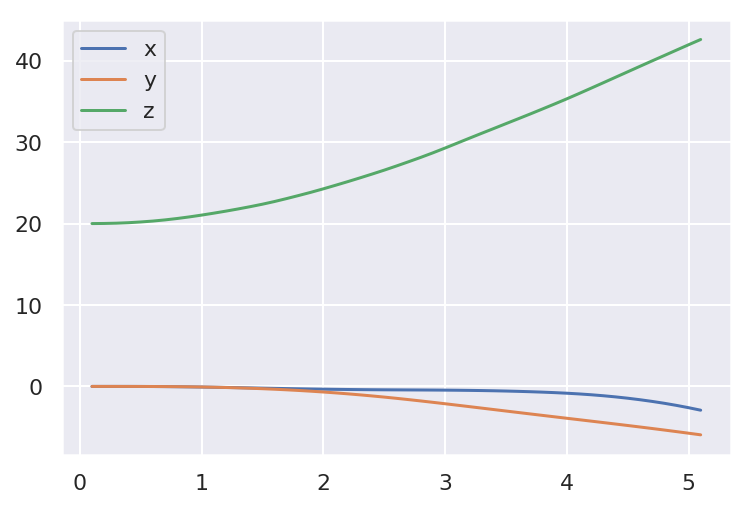

In [4]:
plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

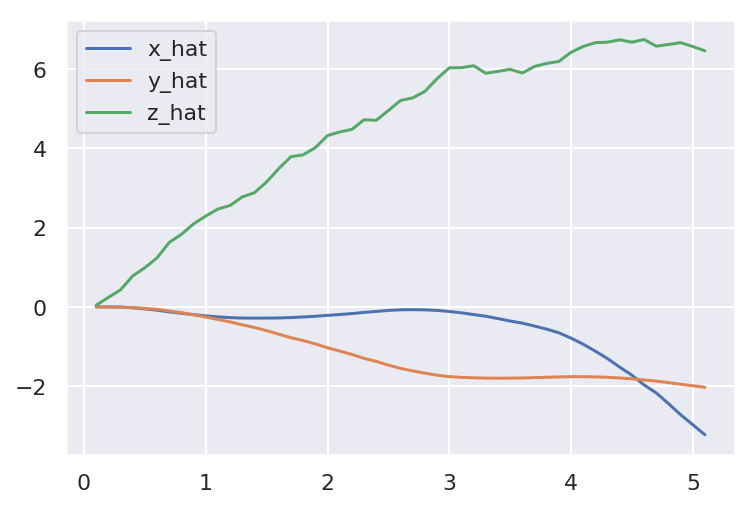

In [5]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

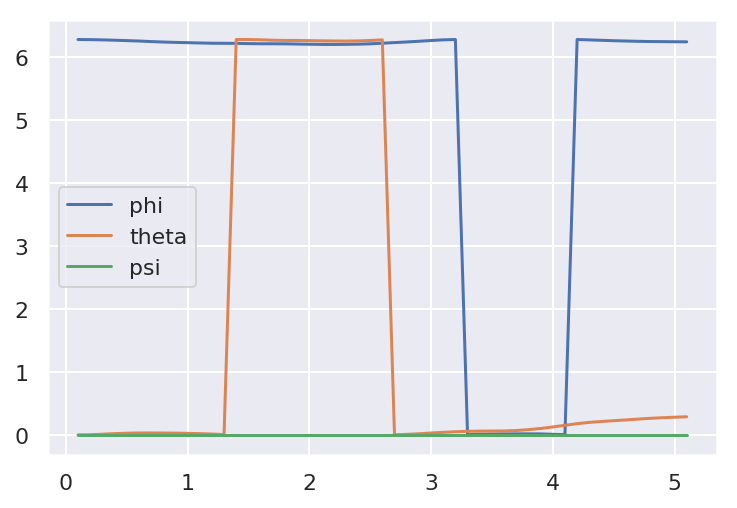

In [6]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

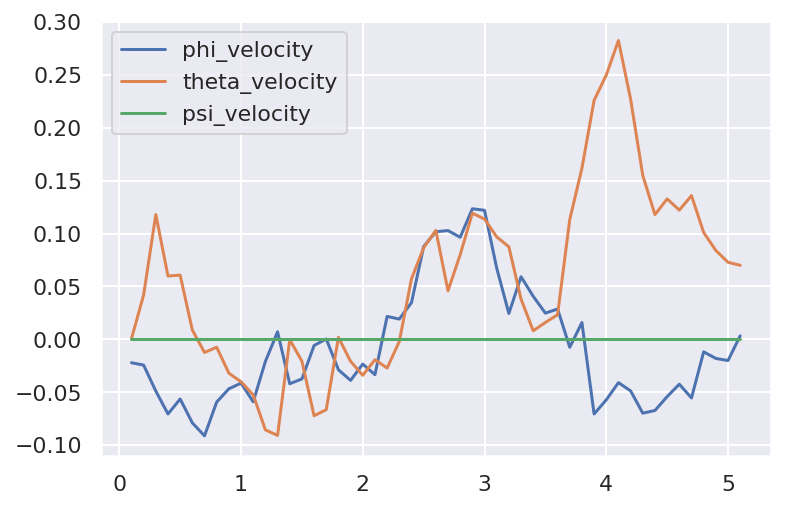

In [7]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

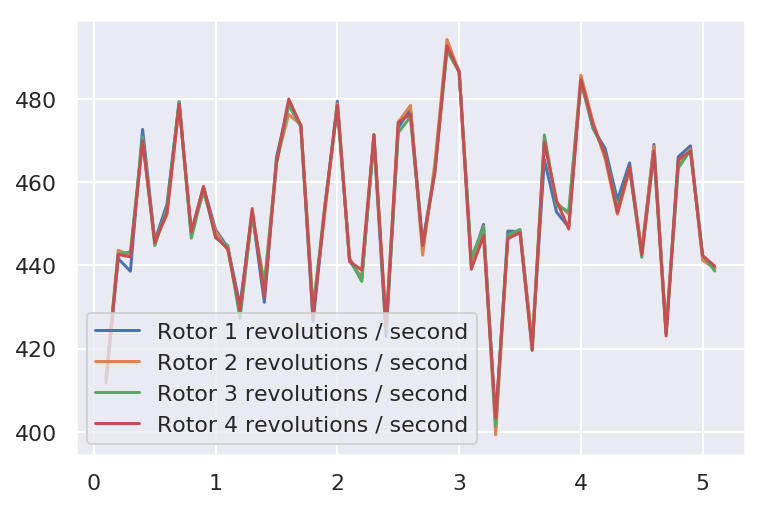

In [8]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [9]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print("Quadcopter pose (x,y,z,phi,theta,psi):\n{}\n".format(task.sim.pose))
print("Quadcopter velocities (v_x,v_y,v_z):\n{}\n".format(task.sim.v))
print("Quadcopter angular velocities (v_phi,v_theta,v_psi):\n{}\n".format(task.sim.angular_v))

Quadcopter pose (x,y,z,phi,theta,psi):
[-2.92078191 -5.94628573 42.61281202  6.24563598  0.28699066  0.        ]

Quadcopter velocities (v_x,v_y,v_z):
[-3.22607424 -2.02783844  6.45407172]

Quadcopter angular velocities (v_phi,v_theta,v_psi):
[0.00333771 0.07000395 0.        ]



## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [10]:
num_episodes = 500

# define initial state variables and target for the quad to rise up to
target_pos = np.array([0., 0., 80.])
init_pose = np.array([0.,0.,40.,0.,0.,0.])

# define the task i.e to take off
task = Task(init_pose=init_pose,target_pos=target_pos,runtime=5.)

# initialize agent
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    # reset_state
    state = agent.reset_episode()
    while True:
        action = agent.act(state)
        next_state, reward, done = agent.task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")
            break
    sys.stdout.flush()

Episode =    7, score =   1.619 (best =   1.626), noise_scale = 0.85

/home/jsingh/learning/RL_quadcopter/physics_sim.py:115: RuntimeWarning: invalid value encountered in double_scalars
  J = V / n * D
/home/jsingh/learning/RL_quadcopter/physics_sim.py:115: RuntimeWarning: divide by zero encountered in double_scalars
  J = V / n * D


Episode =  500, score =   1.969 (best =   2.037), noise_scale = 3.2

This agent should perform very poorly on this task.

## Task

Though we can select from a range of different tasks for the quadcopter, in this notebook we want the agent to learn to take-off. The task is defined in `task.py`. Remember that depending on how we formulate the reward function, the nature of our task and agents ability to learn it efficienty will change.

Though there is a separate field called **Inverse Reinforcement learning** that explores the best reward function to be used for a given task, here the reward function was designed using trial and error and using common sense in order to ensure that our reward function encourages the quadcopter to take-off in a smooth fashion.

In [16]:
# define initial state variables and target for the quad to rise up to
target_pos = np.array([0., 0., 80.])
init_pose = np.array([0.,0.,20.,0.,0.,0.])

# define the task i.e to take off
task = Task(init_pose=init_pose,target_pos=target_pos,runtime=10.)

# initialize the RL agent
agent = Agent(state_size=task.state_size,action_size=task.action_size,
              single_rotor_control=False,buffer_size=int(1e5),batch_size=128,
              gamma=0.99,tau=1e-3,lr_actor=1e-4,lr_critic=1e-3,random_seed=0)

In [17]:
# train function for the ddpg agent
def ddpg_train(agent,env=task,max_episodes=int(1e4),PRINT_EVERY=100,DISPLAY_EVERY=50):
    
    # initialize logs for storing episode rewards
    episode_rewards = []
    episode_reward_window = deque(maxlen=100)
    
    for eps_count in range(max_episodes):
        
        # initialize time step counter and online reward
        time_step = 0
        online_reward = 0
        
        # initialize logs for storing quad movements
        state_log, action_log, v_log, angular_v_log = [],[],[],[]
        
        # reset agent
        state = env.reset()
        
        while True:
            # choose agent action
            action = agent.act(state)
            
            # map action to appropriate range
            action_ = (env.action_high - env.action_low)*(action+1)/2 + env.action_low
            
            # take the next step in the env using the above action
            next_state,reward,done = env.step(action_)
            
            # take agent update step
            agent.step(state, action, reward, next_state, done)
            
            # update quad movement logs
            state_log.append(env.sim.pose)
            action_log.append(action_)
            v_log.append(env.sim.v)
            angular_v_log.append(env.sim.angular_v)
            
            # update online reward and time-step counter
            online_reward += reward
            time_step += 1
            
            # update state
            state = next_state
            
            if done:
                # update episode rewards log
                episode_rewards.append(online_reward)
                episode_reward_window.append(online_reward)
                break

        # print training progress
        if eps_count%PRINT_EVERY == 0:
            print ("Episode: {}\t Avg reward: {:.2f}\t Current reward: {:.2f}\t Episode length: {}\n".format(eps_count,
                                                            np.mean(episode_reward_window),online_reward,time_step))
        # visualize quad movements
        if eps_count%DISPLAY_EVERY == 0:
            # figure
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

            # plot (x,y,z) movements of the quad
            state_log = np.array(state_log)
            labels = ['x','y','z']
            for i in range(len(labels)):
                ax[0,0].plot(state_log[:,i],label=labels[i])
            ax[0,0].set_ylim([-10,120])
            ax[0,0].set_xlim([-10,100])
            ax[0,0].legend()
            #ax[0,0].set_xlabel('timesteps')

            # plot rotor speeds of the quad
            action_log = np.array(action_log)
            labels = ['rotor 1 speed','rotor 2 speed','rotor 3 speed','rotor 4 speed']
            for i in range(len(labels)):
                ax[0,1].plot(action_log[:,i],label=labels[i])
            ax[0,1].set_ylim([-100,1000])
            ax[0,1].set_xlim([-10,100])
            ax[0,1].legend()
            #ax[0,1].set_xlabel('timesteps')

            # plot movements of the quad along the euler angles (phi,theta,psi)
            labels = ['phi','theta','psi']
            for i in range(len(labels)):
                ax[1,0].plot(state_log[:,3+i],label=labels[i])
            ax[1,0].set_ylim([-10,10])
            ax[1,0].set_xlim([-10,100])
            ax[1,0].legend()
            ax[1,0].set_xlabel('timesteps')

            # plot angular velocities of the quad along the 3 main axis
            angular_v_log = np.array(angular_v_log)
            labels = ['v_phi','v_theta','v_psi']
            for i in range(len(labels)):
                ax[1,1].plot(angular_v_log[:,i],label=labels[i])
            ax[1,1].set_ylim([-10,10])
            ax[1,1].set_xlim([-10,100])
            ax[1,1].legend()
            ax[1,1].set_xlabel('timesteps')

            fig.suptitle("Quadcopter movement visualization for episode: {}".format(eps_count))
            plt.show()
            
    return episode_rewards

Episode: 0	 Avg reward: -17.27	 Current reward: -17.27	 Episode length: 20



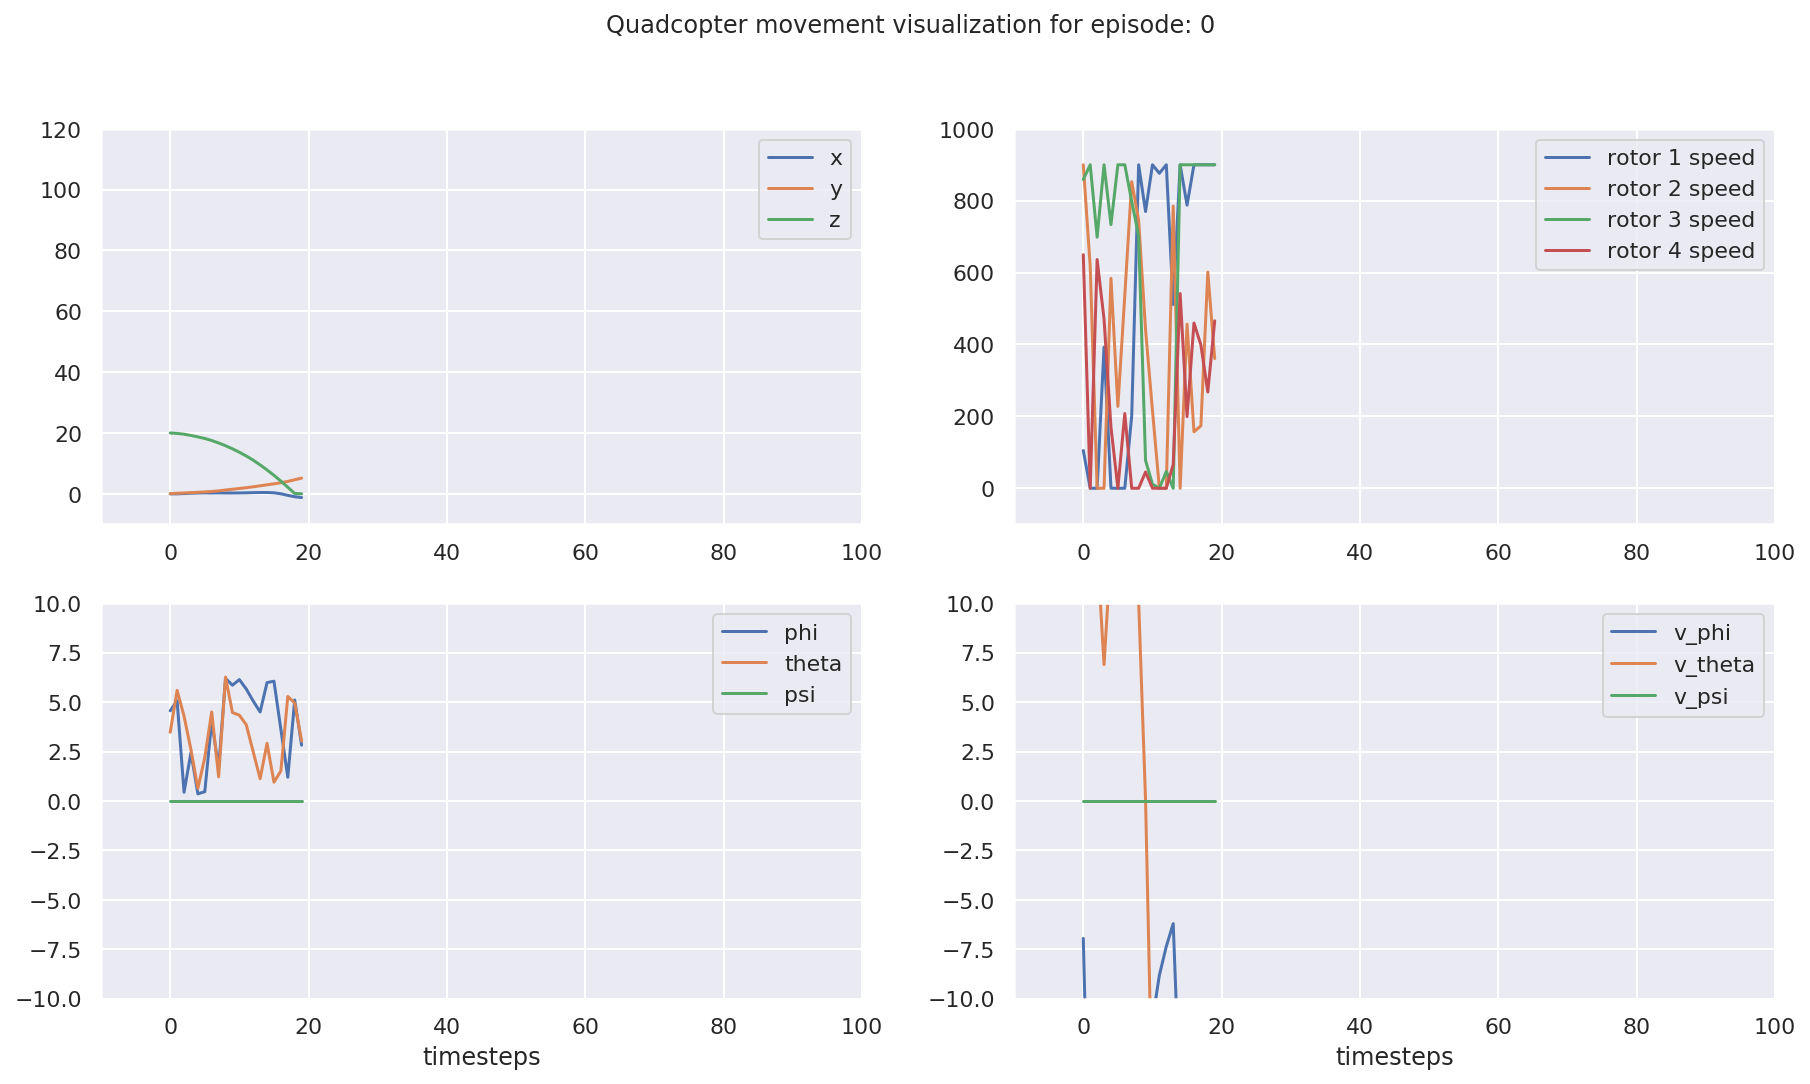

Episode: 200	 Avg reward: 6.59	 Current reward: 16.03	 Episode length: 22



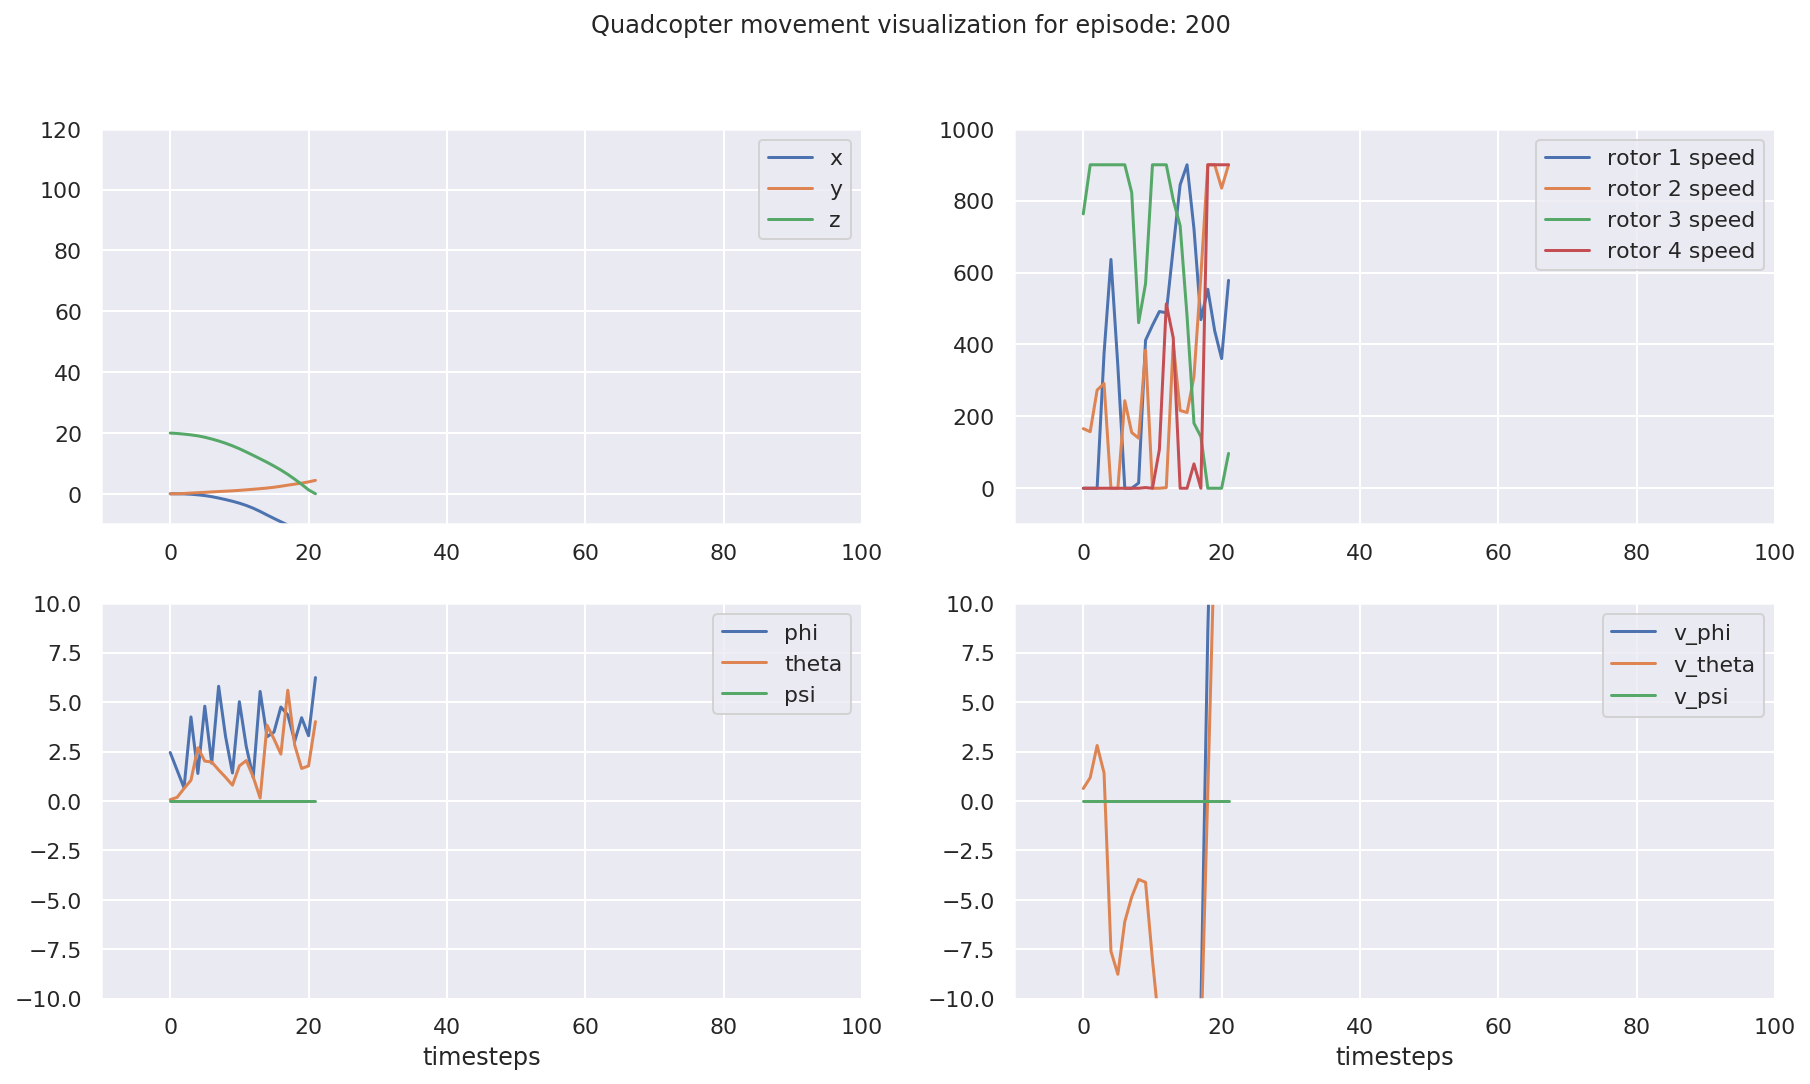

Episode: 400	 Avg reward: 6.90	 Current reward: 1.12	 Episode length: 19



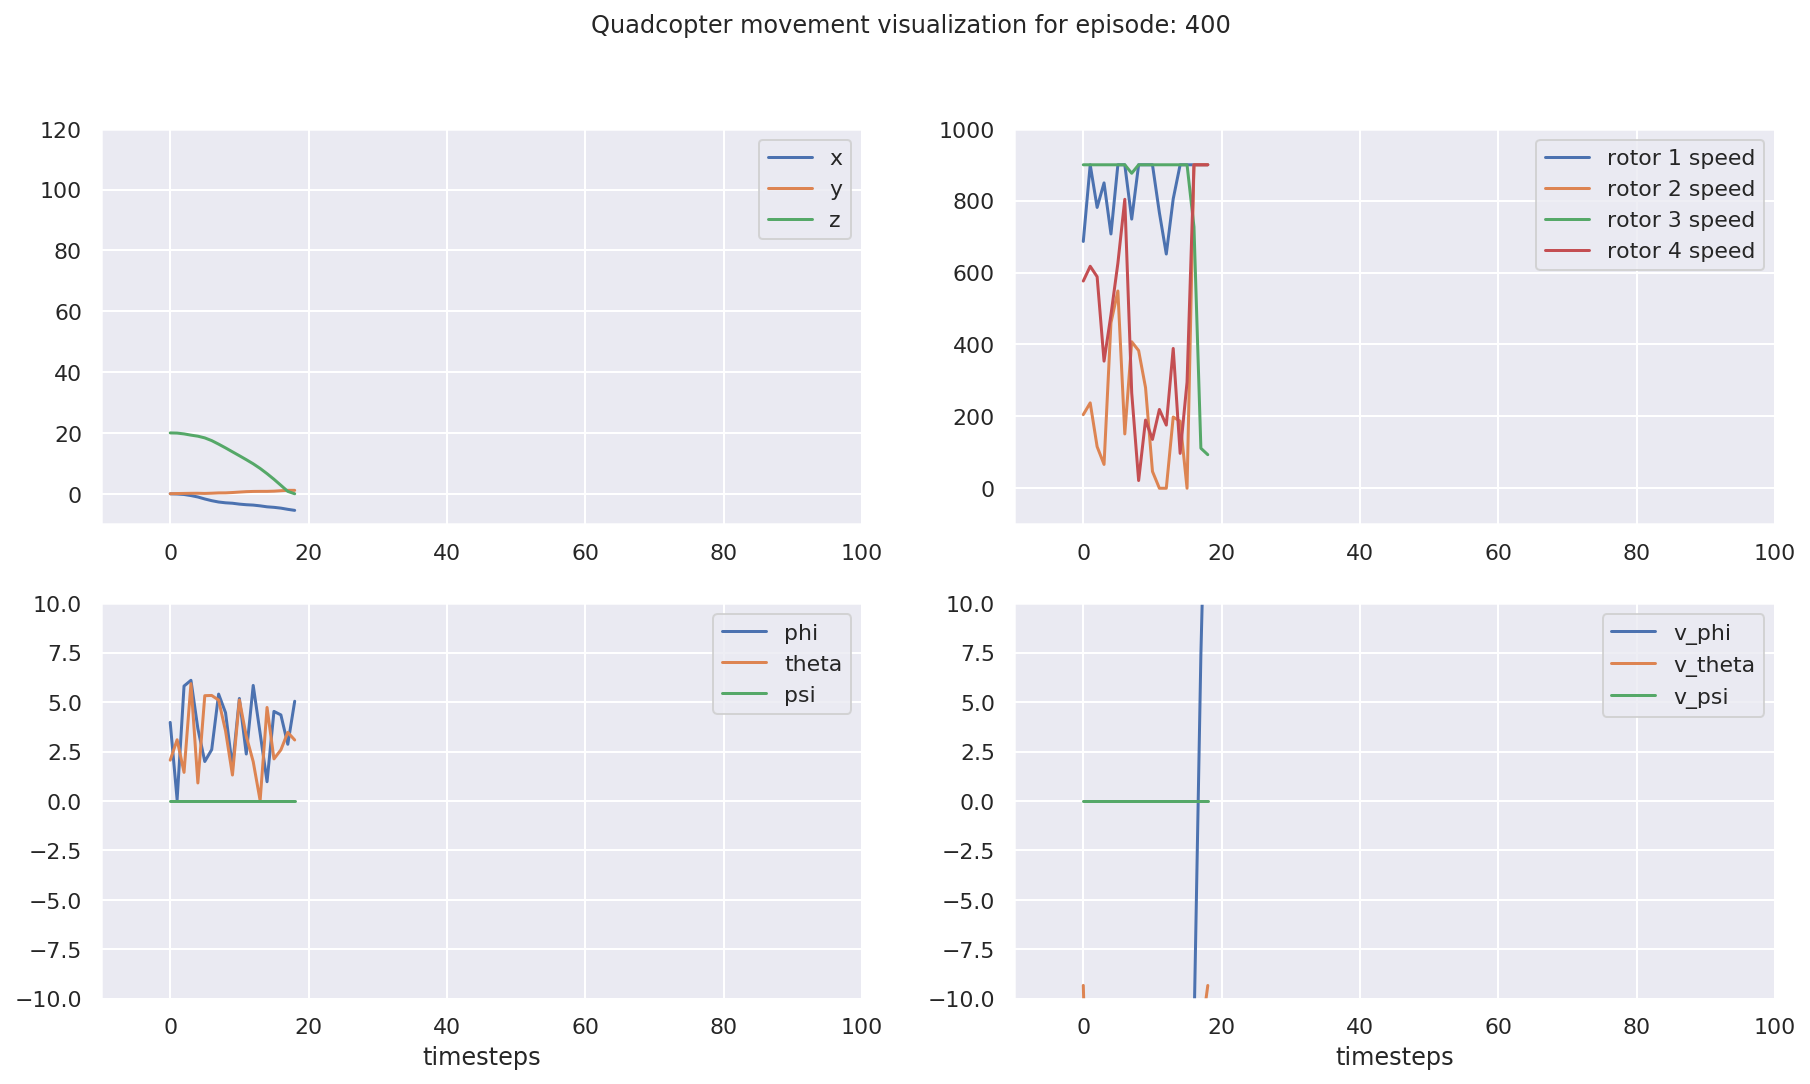

Episode: 600	 Avg reward: 6.18	 Current reward: 23.71	 Episode length: 20



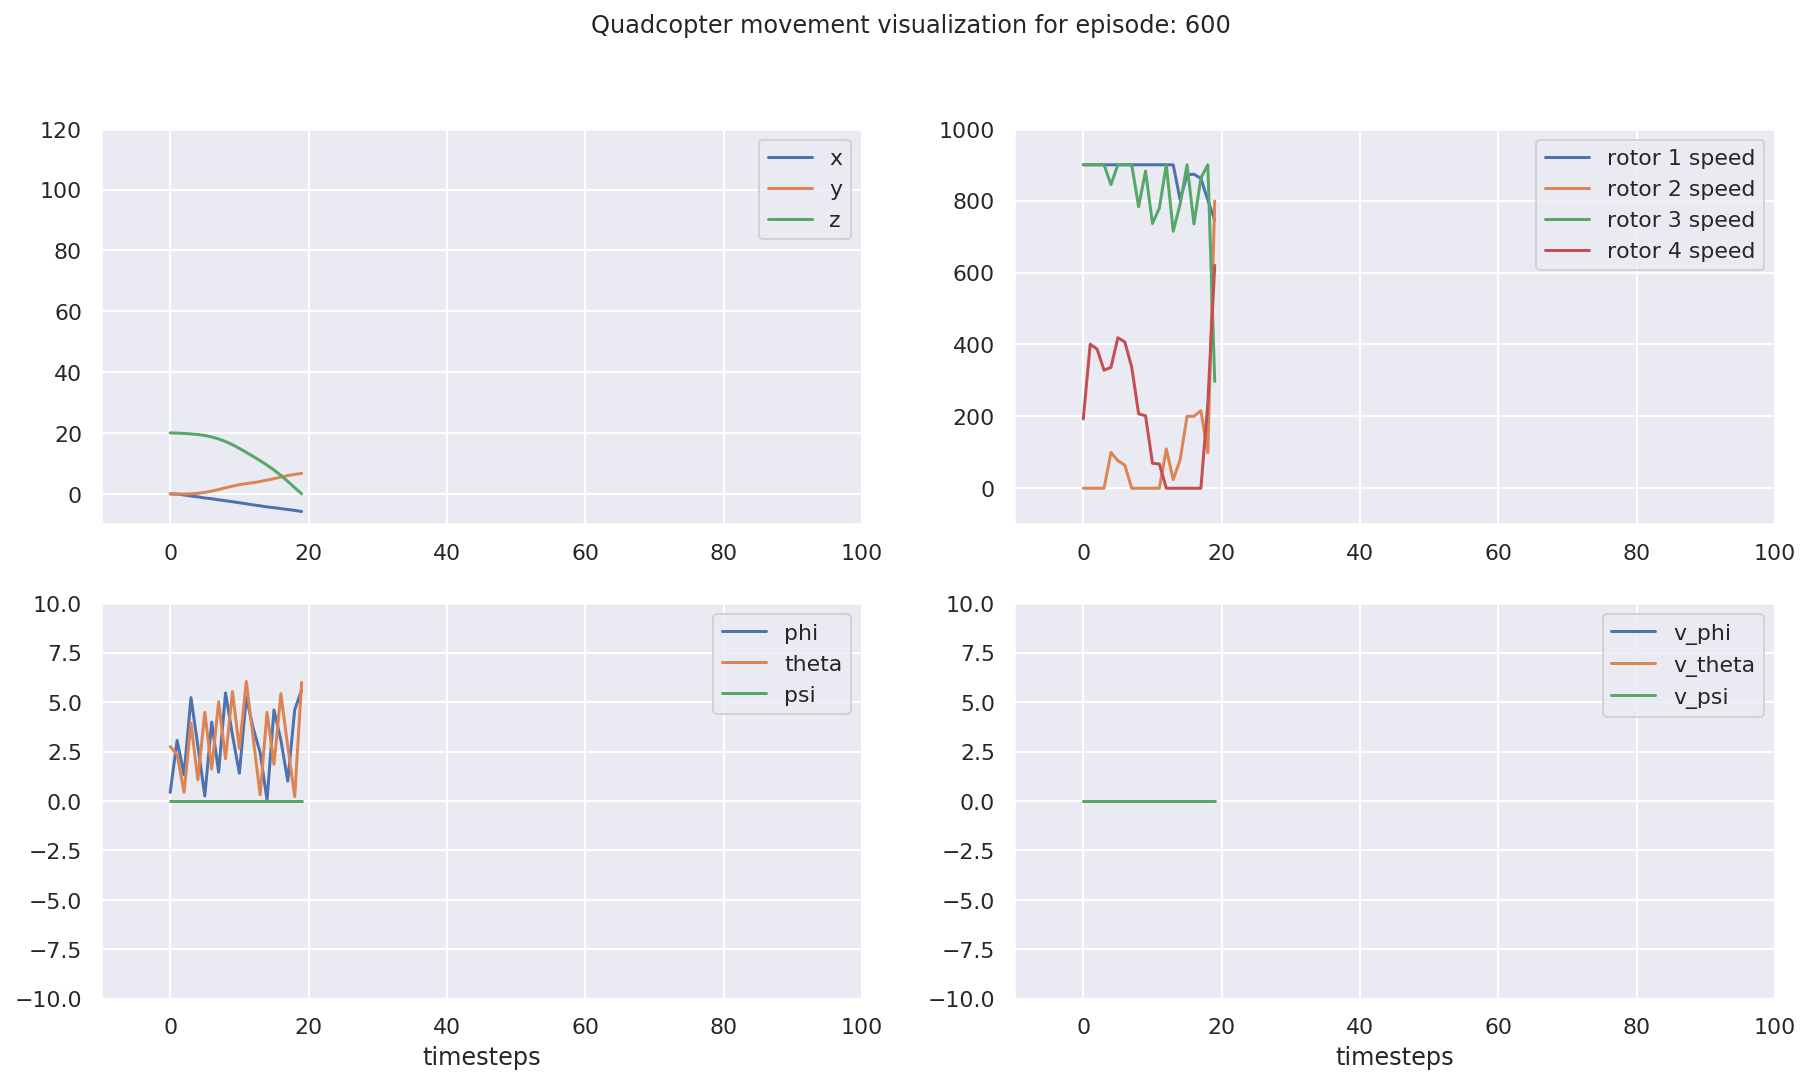

Episode: 800	 Avg reward: 10.74	 Current reward: -3.06	 Episode length: 23



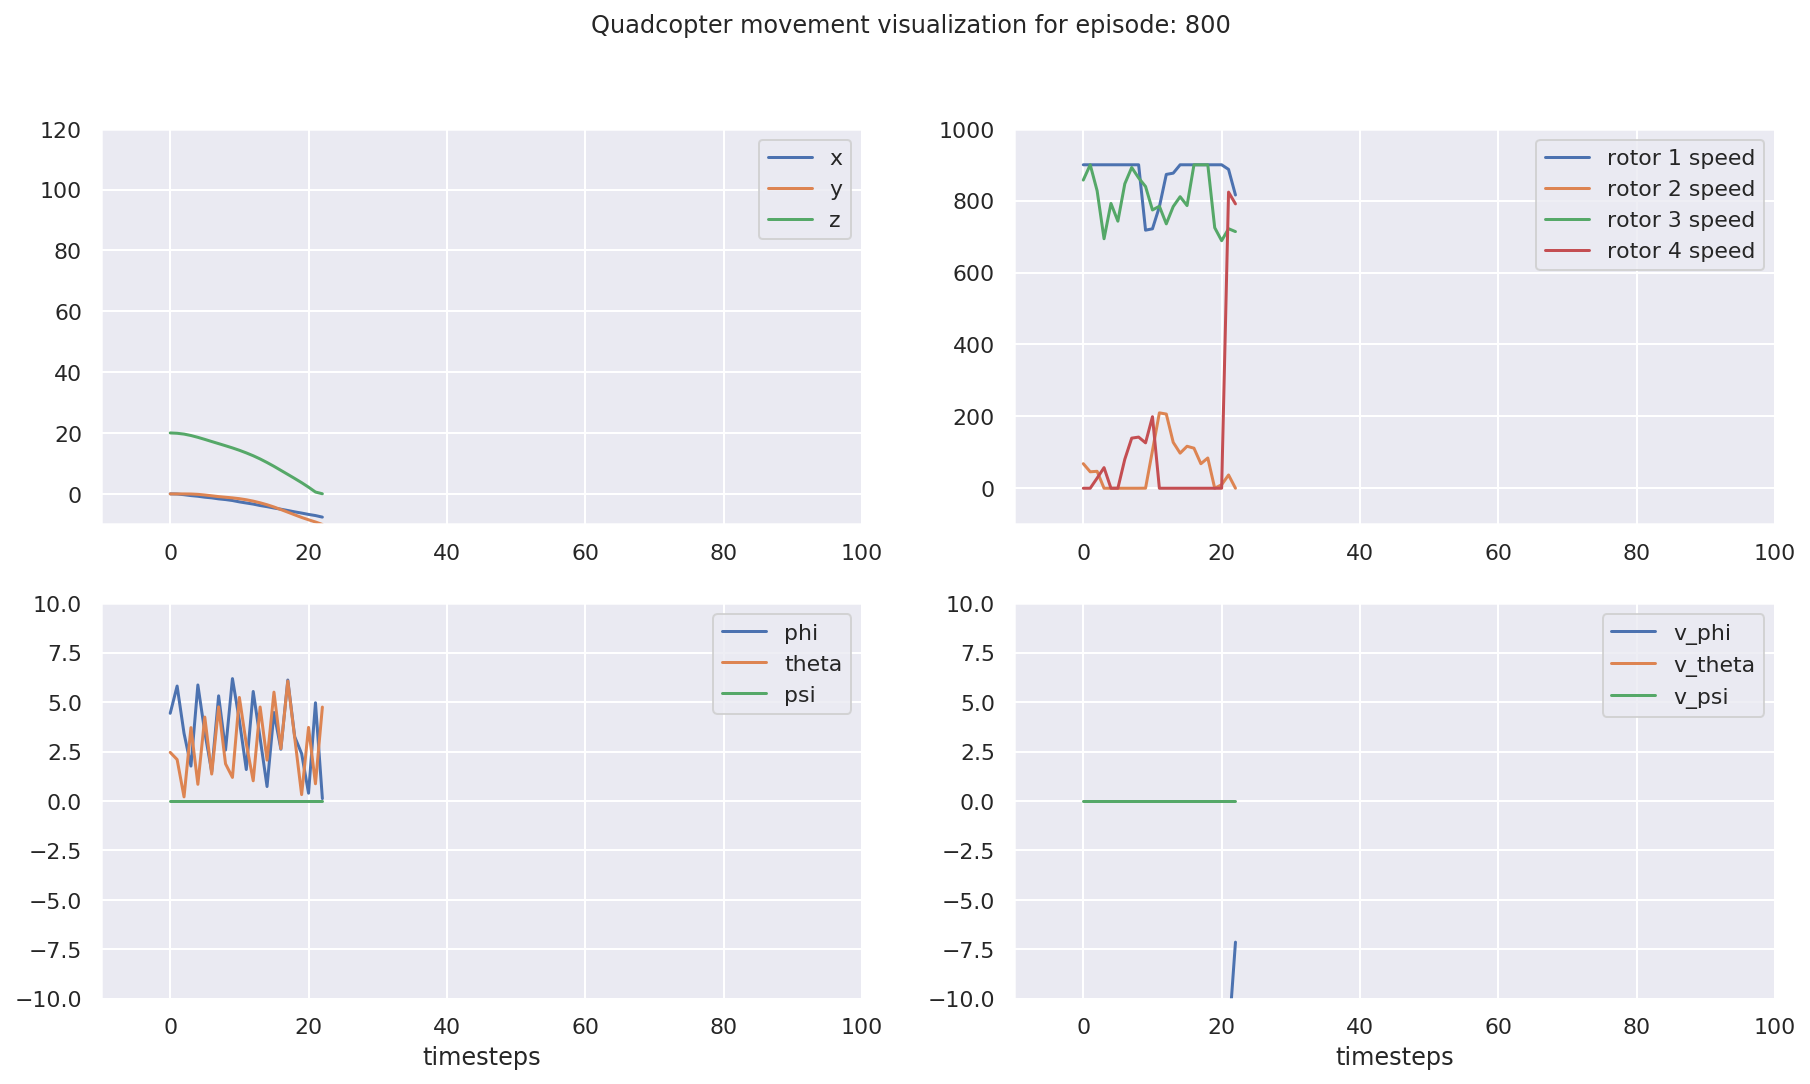

Episode: 1000	 Avg reward: 11.64	 Current reward: 36.78	 Episode length: 32



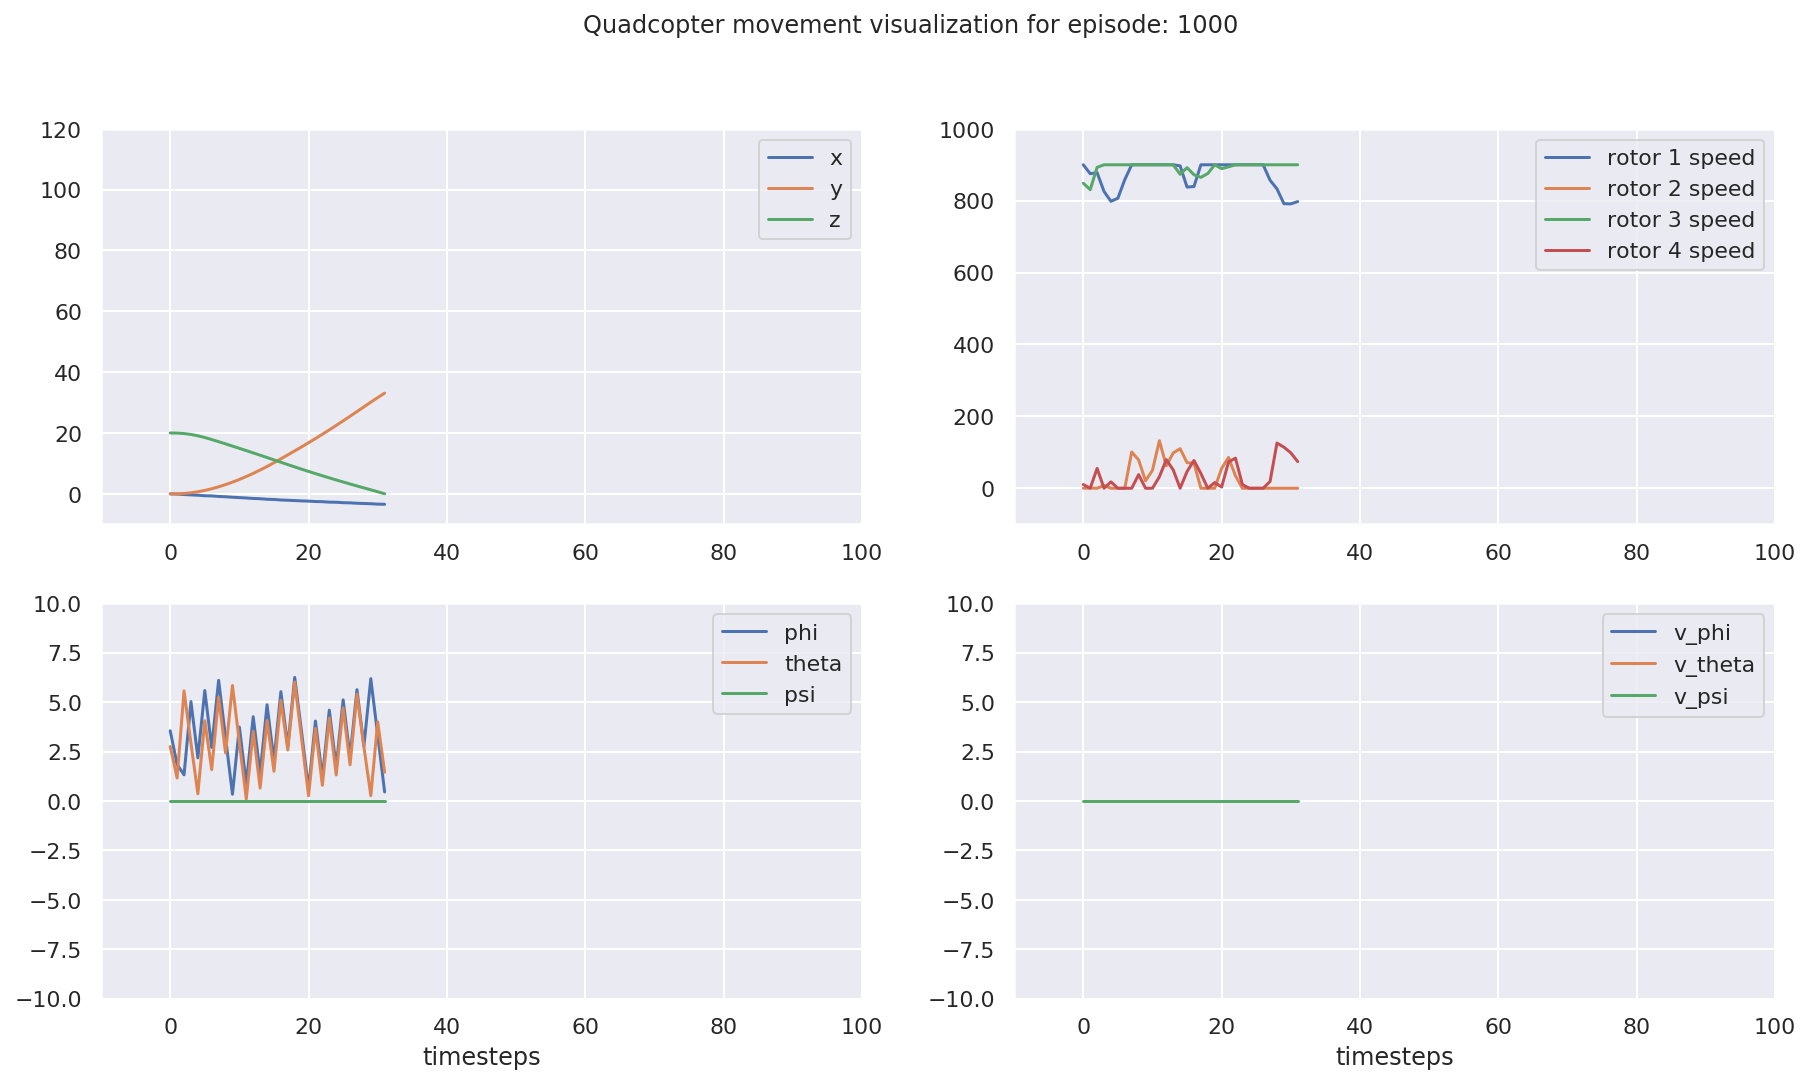

Episode: 1200	 Avg reward: 23.20	 Current reward: 59.14	 Episode length: 51



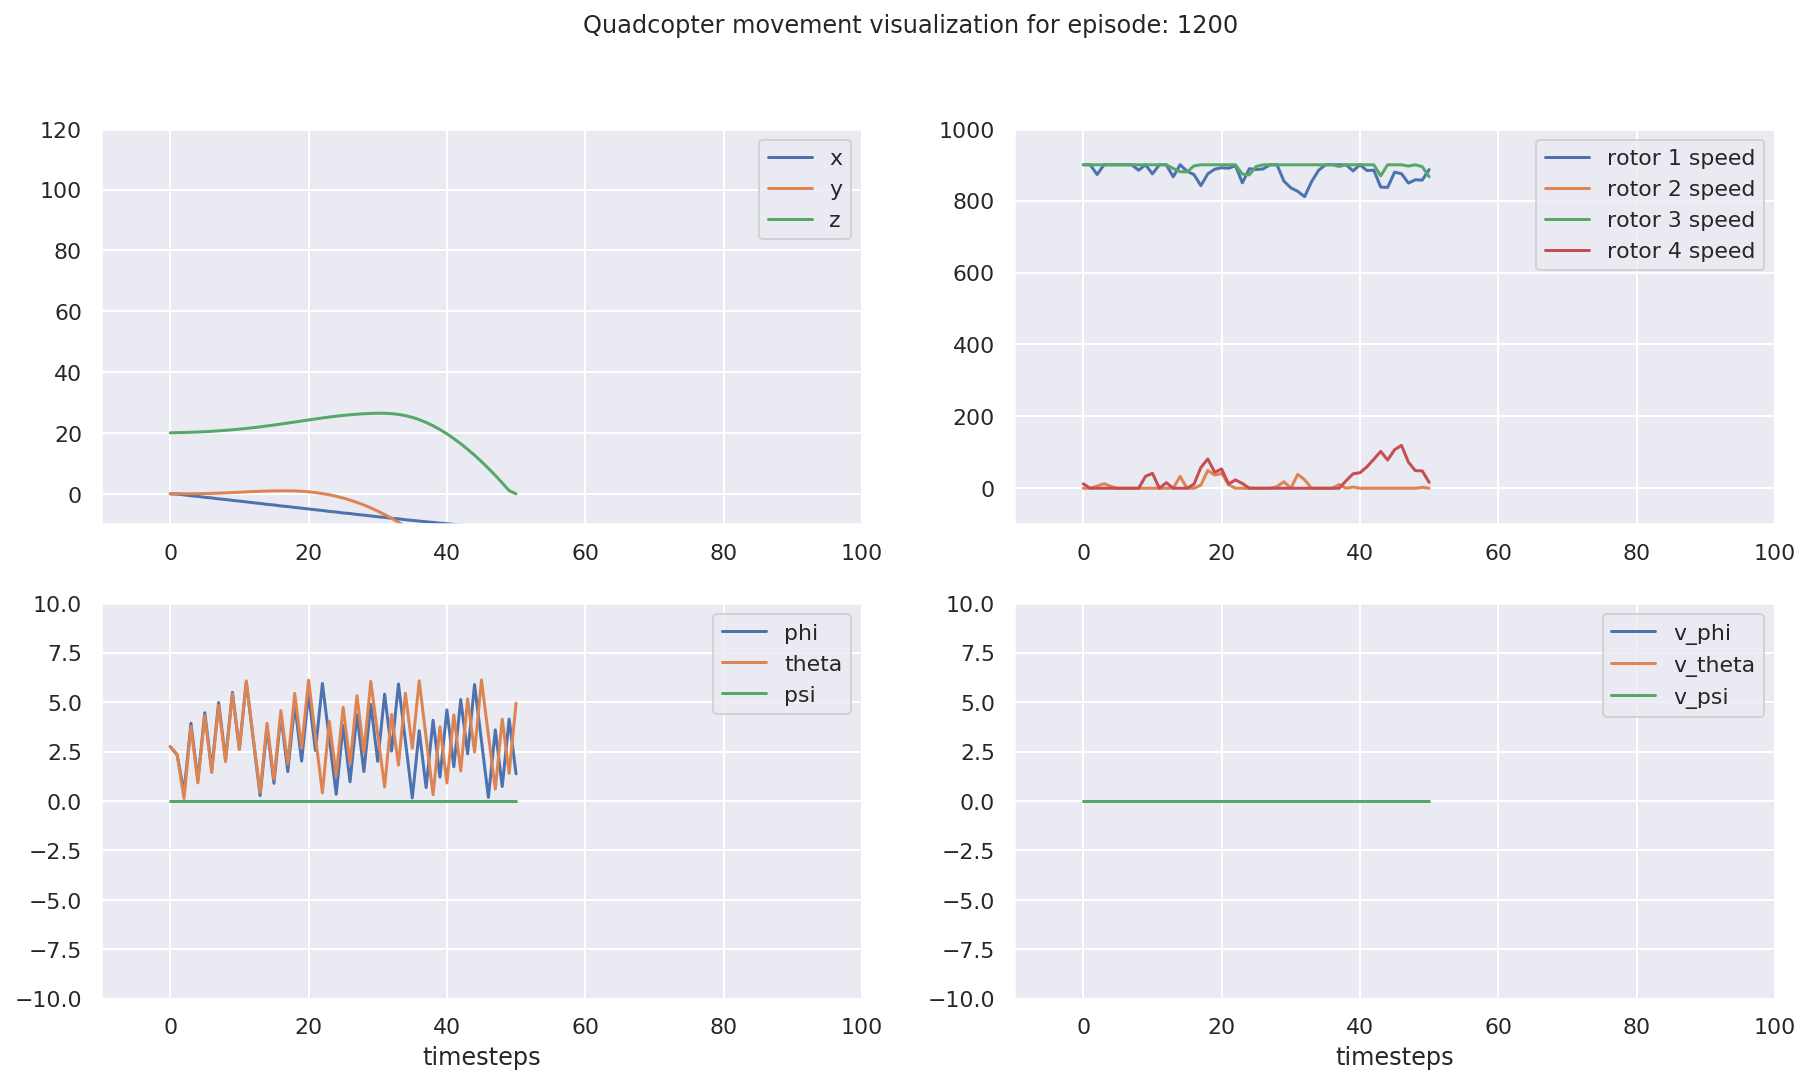

Episode: 1400	 Avg reward: 30.28	 Current reward: 8.06	 Episode length: 17



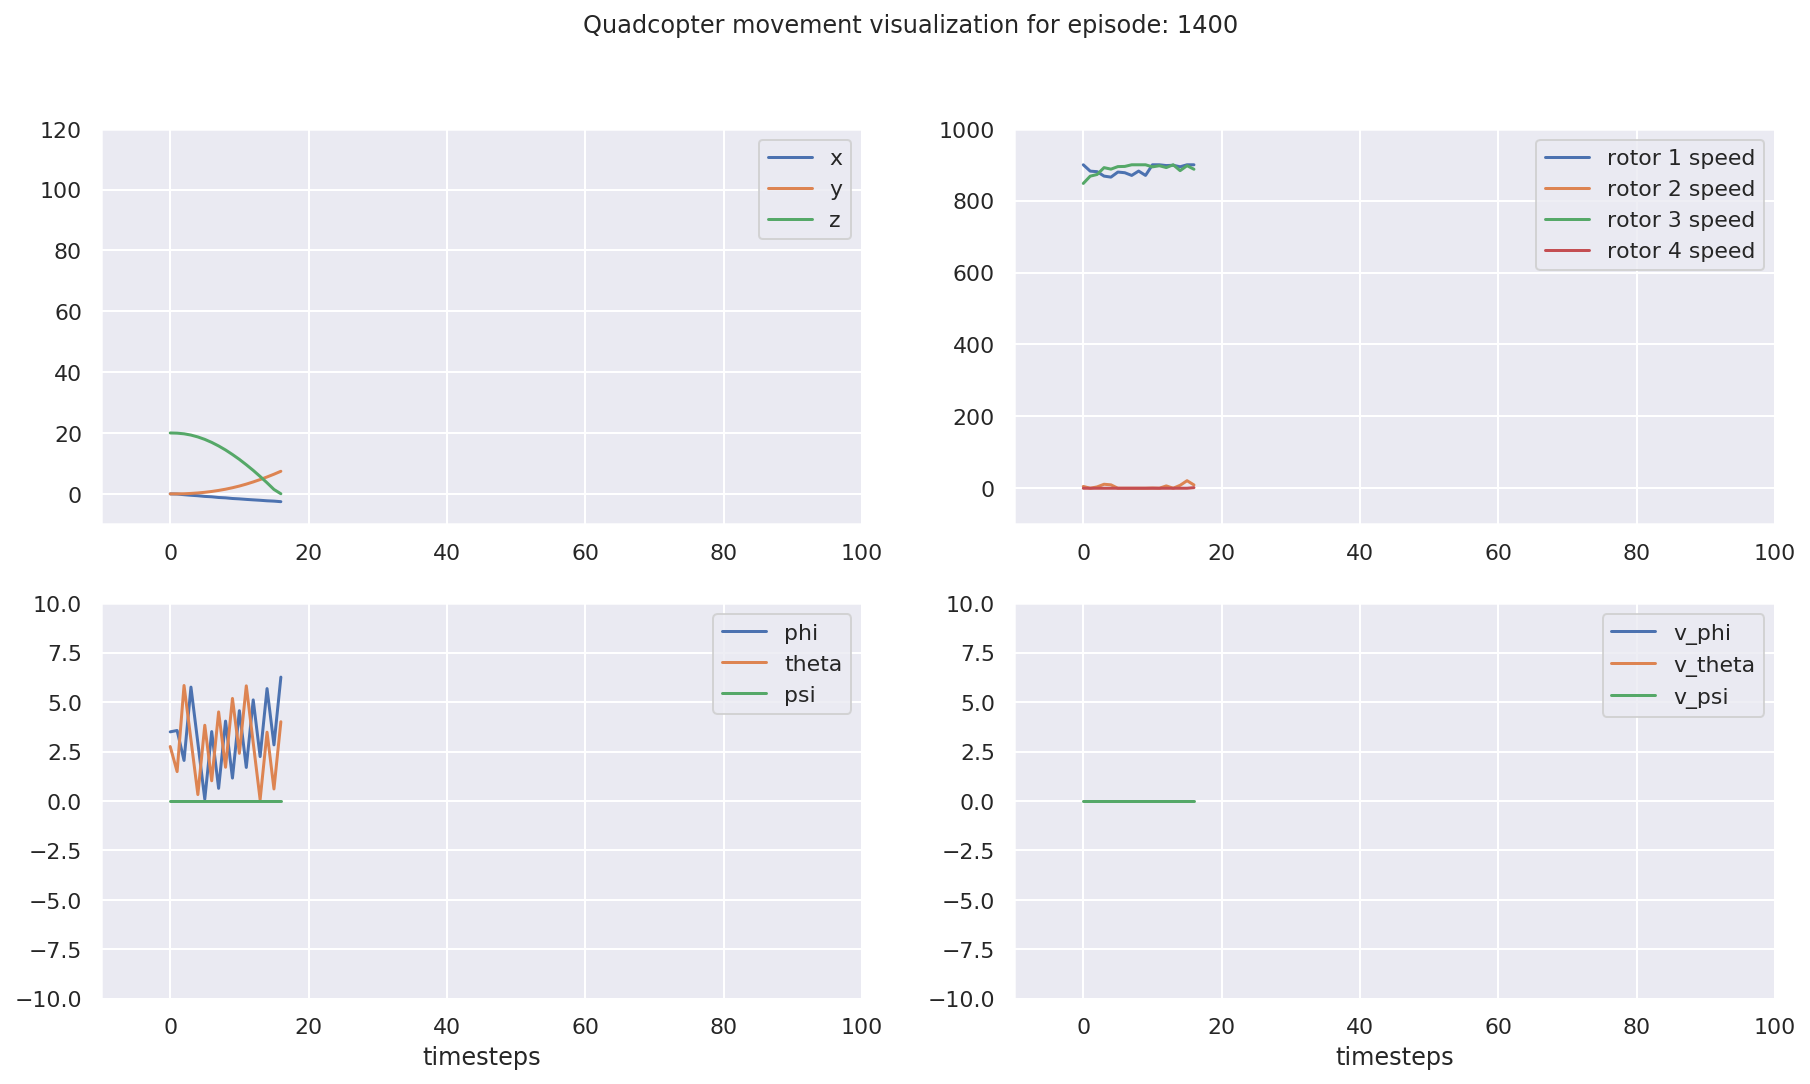

Episode: 1600	 Avg reward: 109.98	 Current reward: 273.78	 Episode length: 101



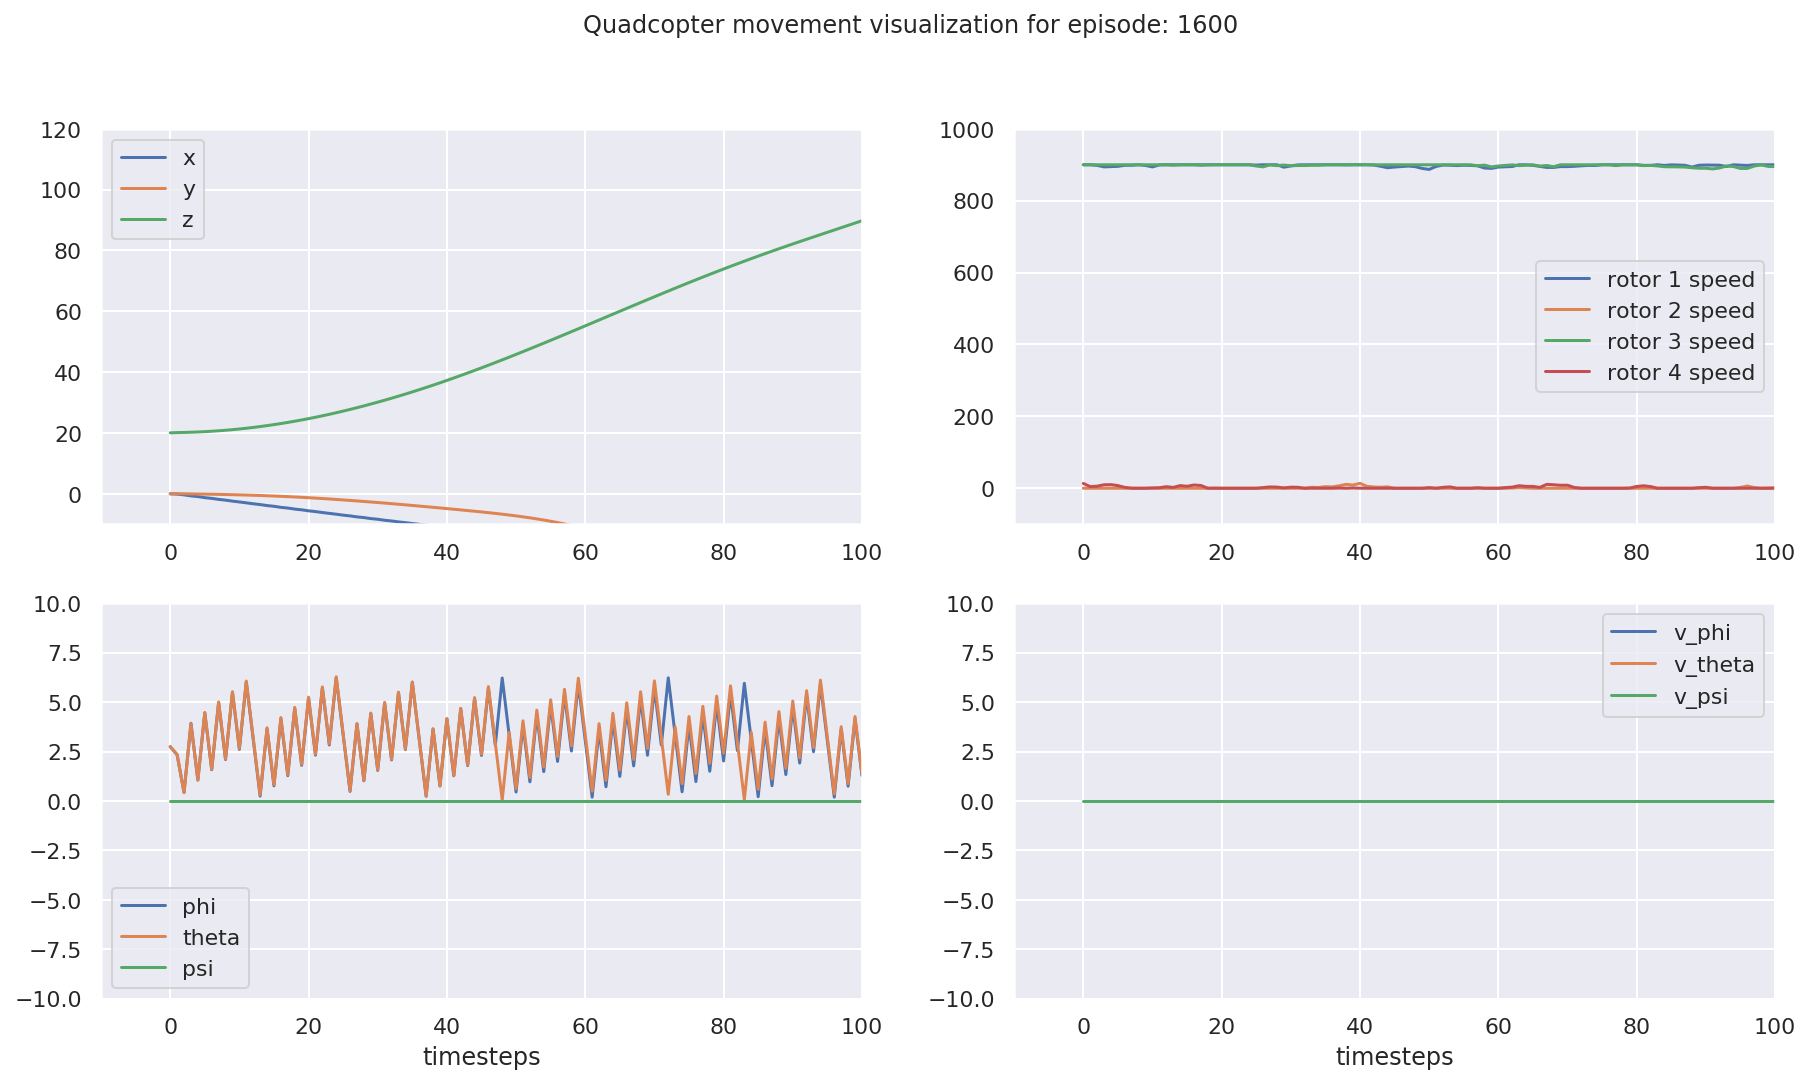

Episode: 1800	 Avg reward: 258.62	 Current reward: 309.34	 Episode length: 101



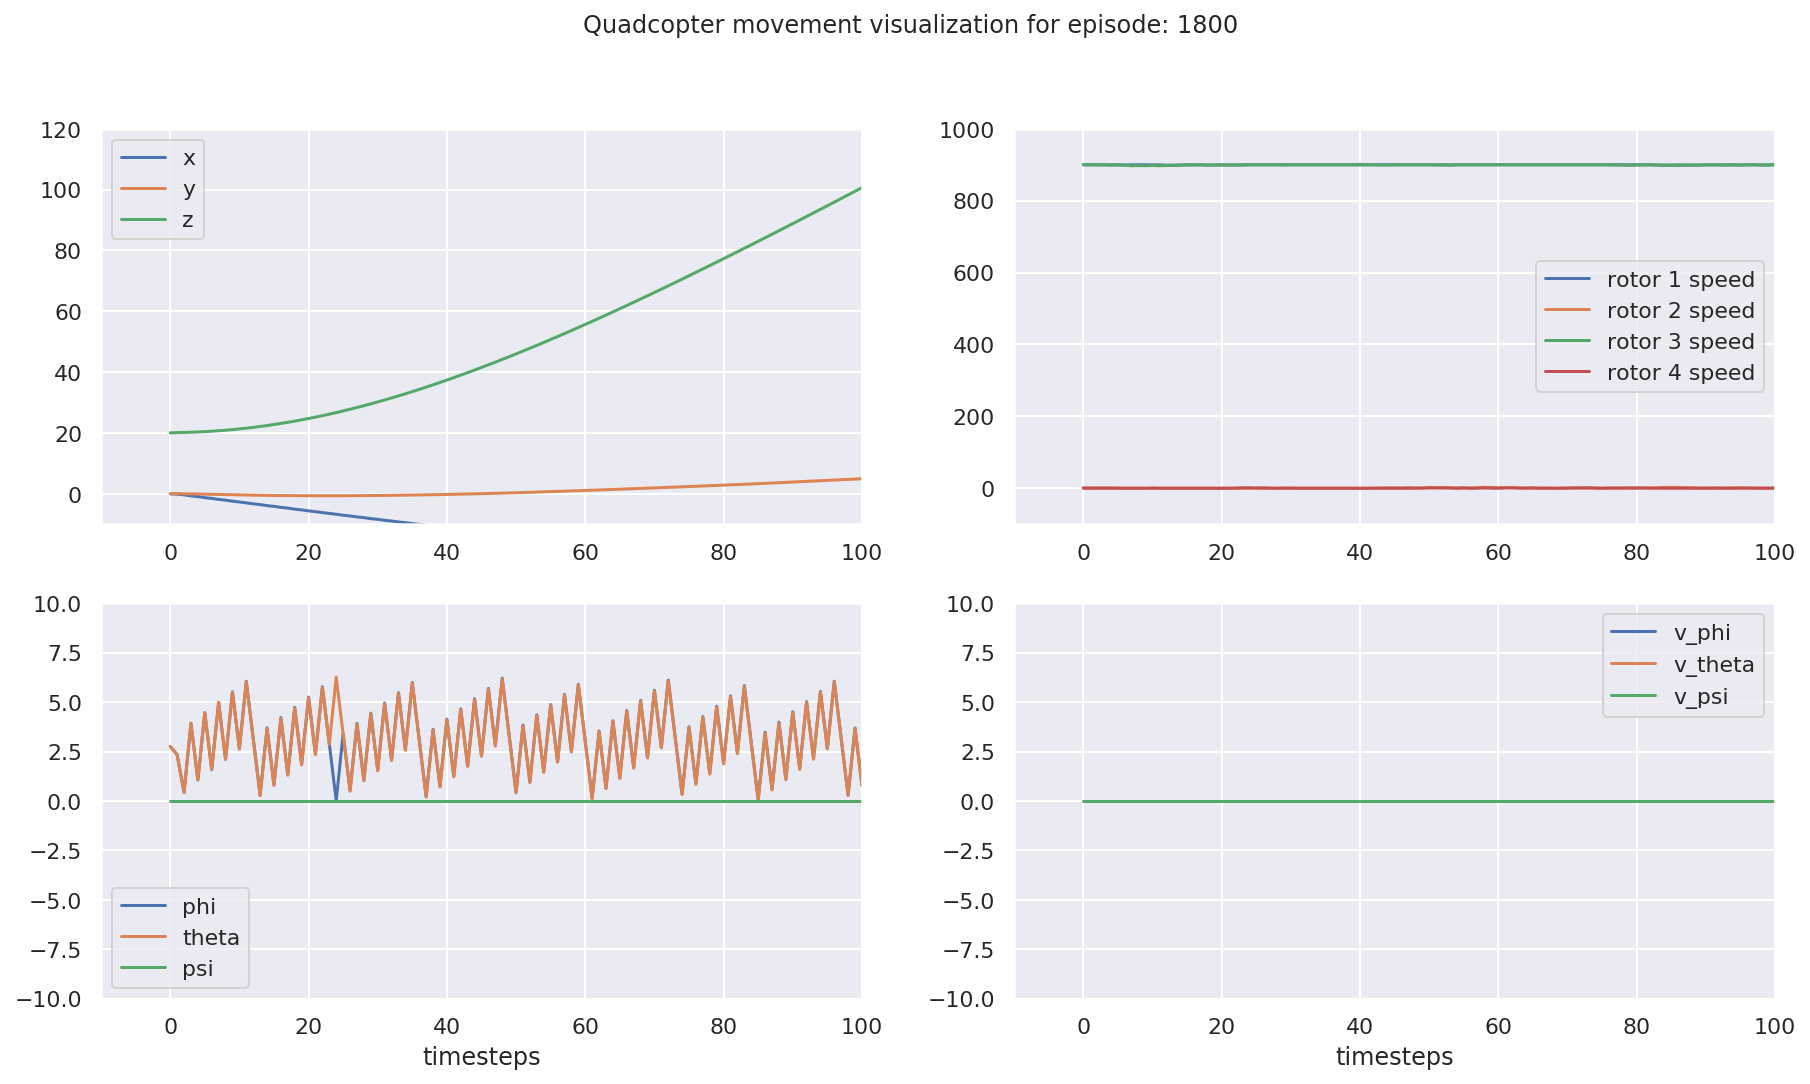

Episode: 2000	 Avg reward: 280.84	 Current reward: 271.29	 Episode length: 101



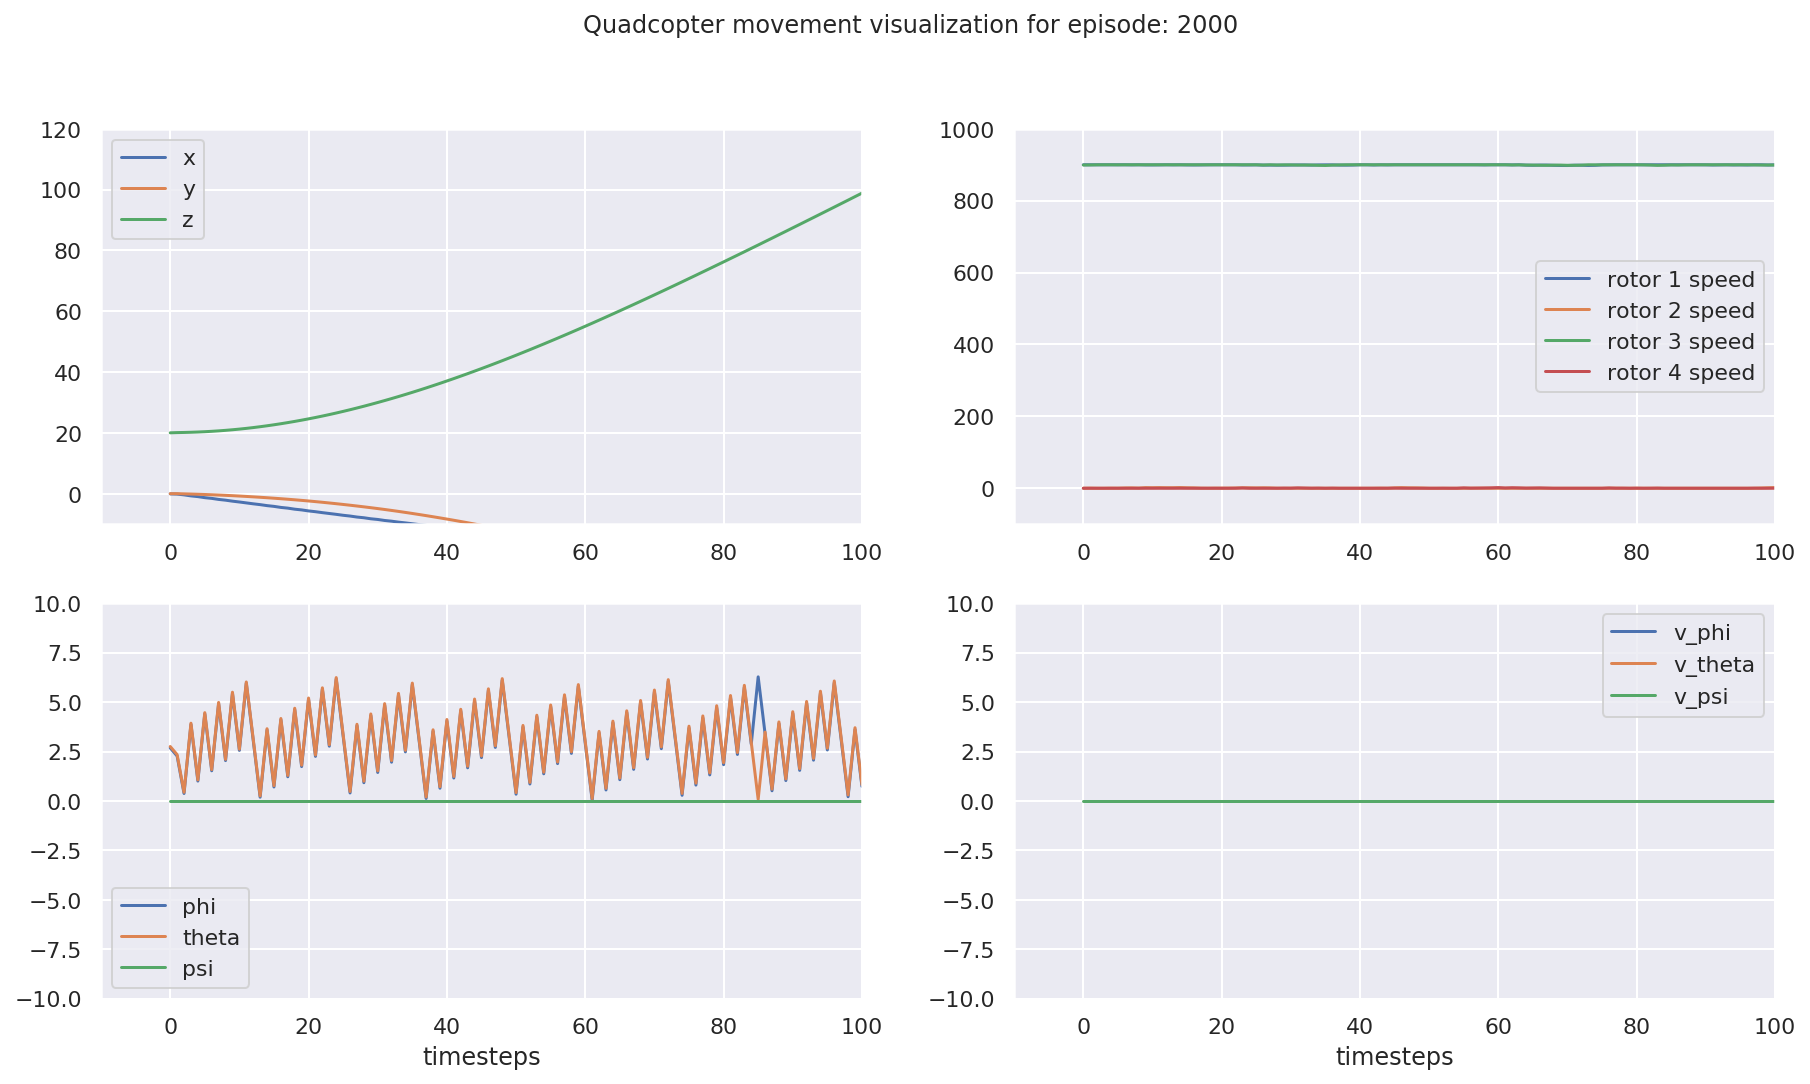

Episode: 2200	 Avg reward: 282.74	 Current reward: 298.48	 Episode length: 101



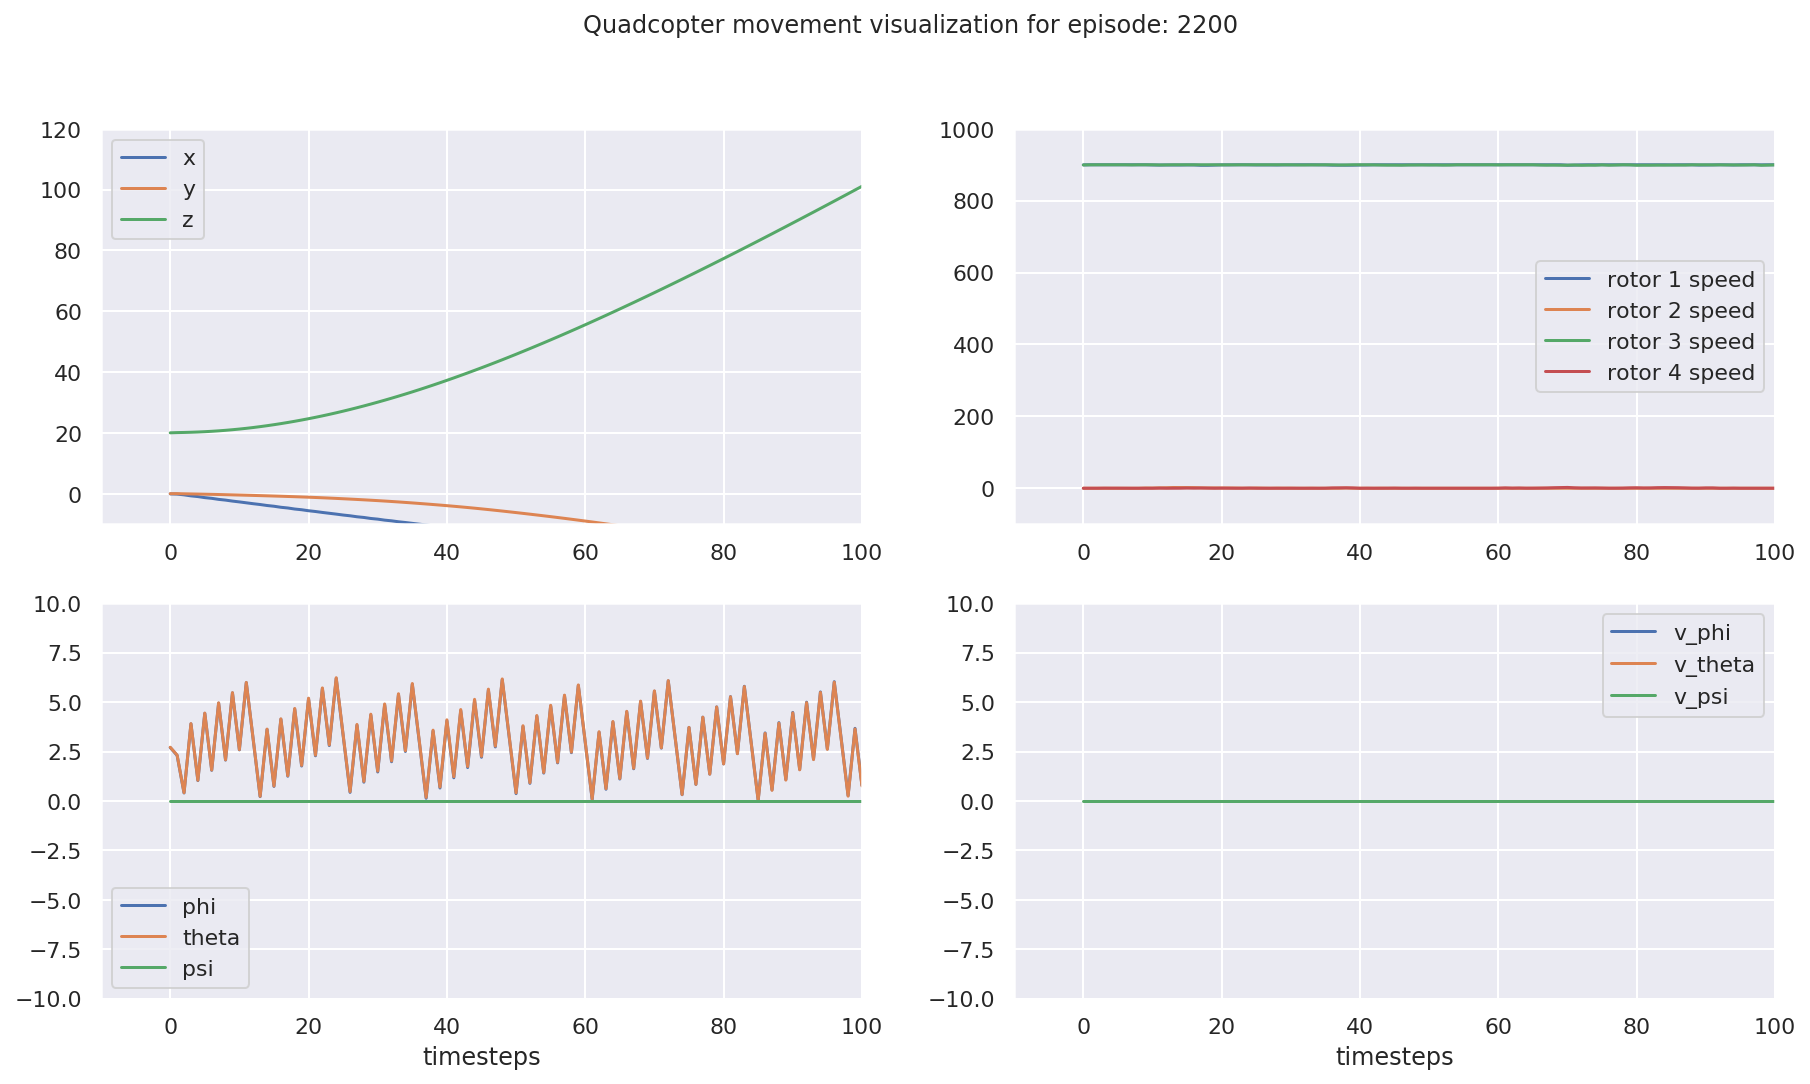

Episode: 2400	 Avg reward: 292.53	 Current reward: 278.97	 Episode length: 101



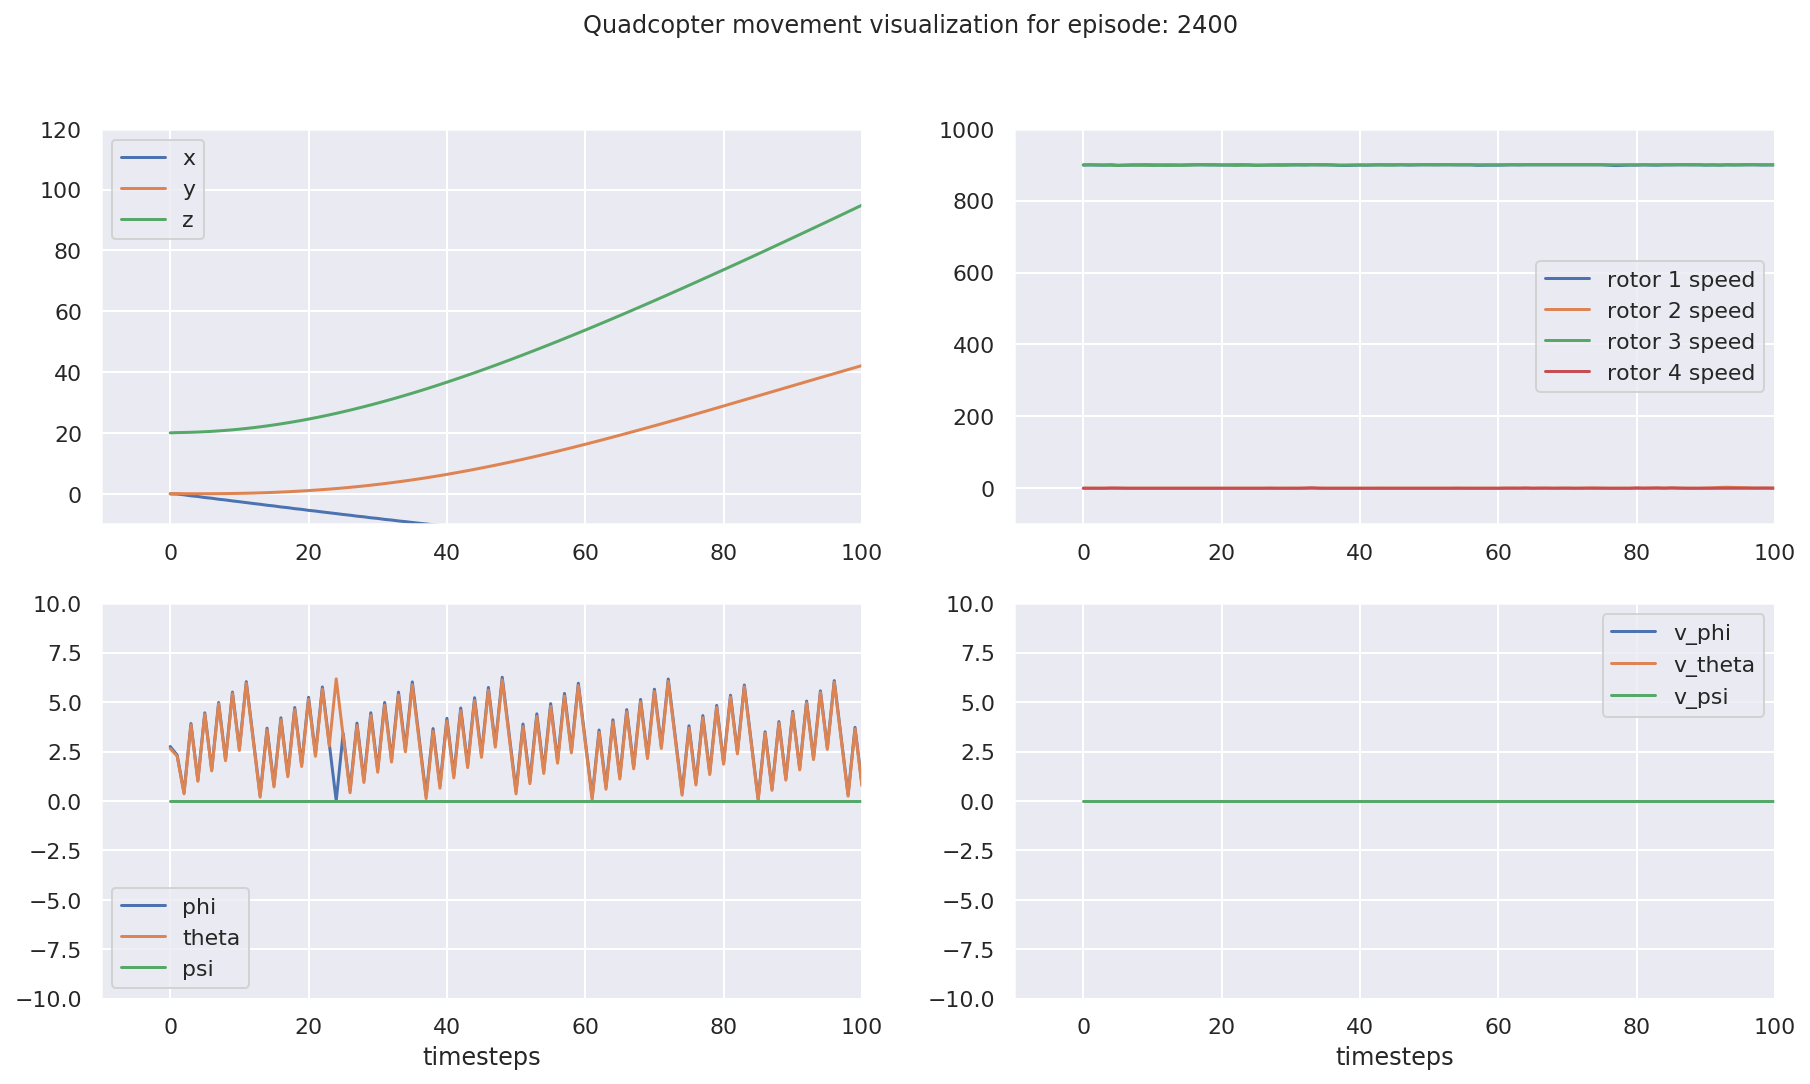

Episode: 2600	 Avg reward: 286.35	 Current reward: 157.30	 Episode length: 101



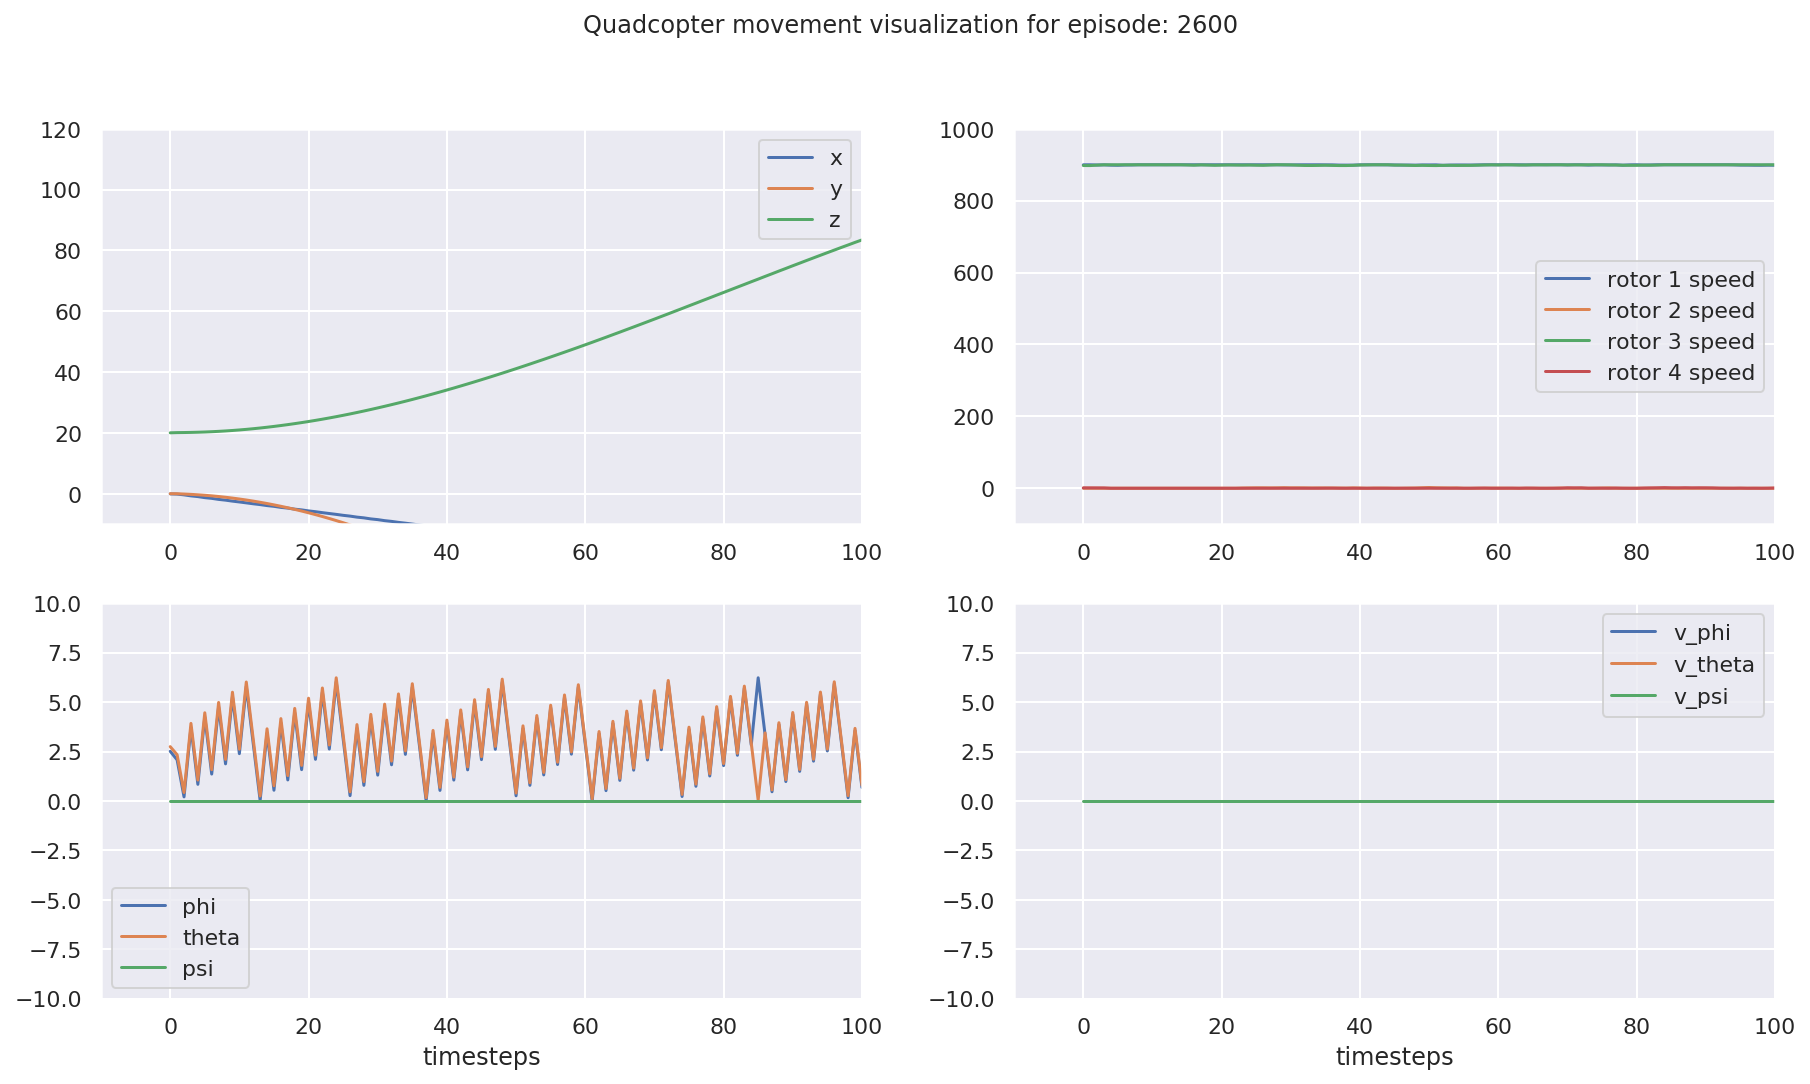

Episode: 2800	 Avg reward: 285.17	 Current reward: 284.39	 Episode length: 101



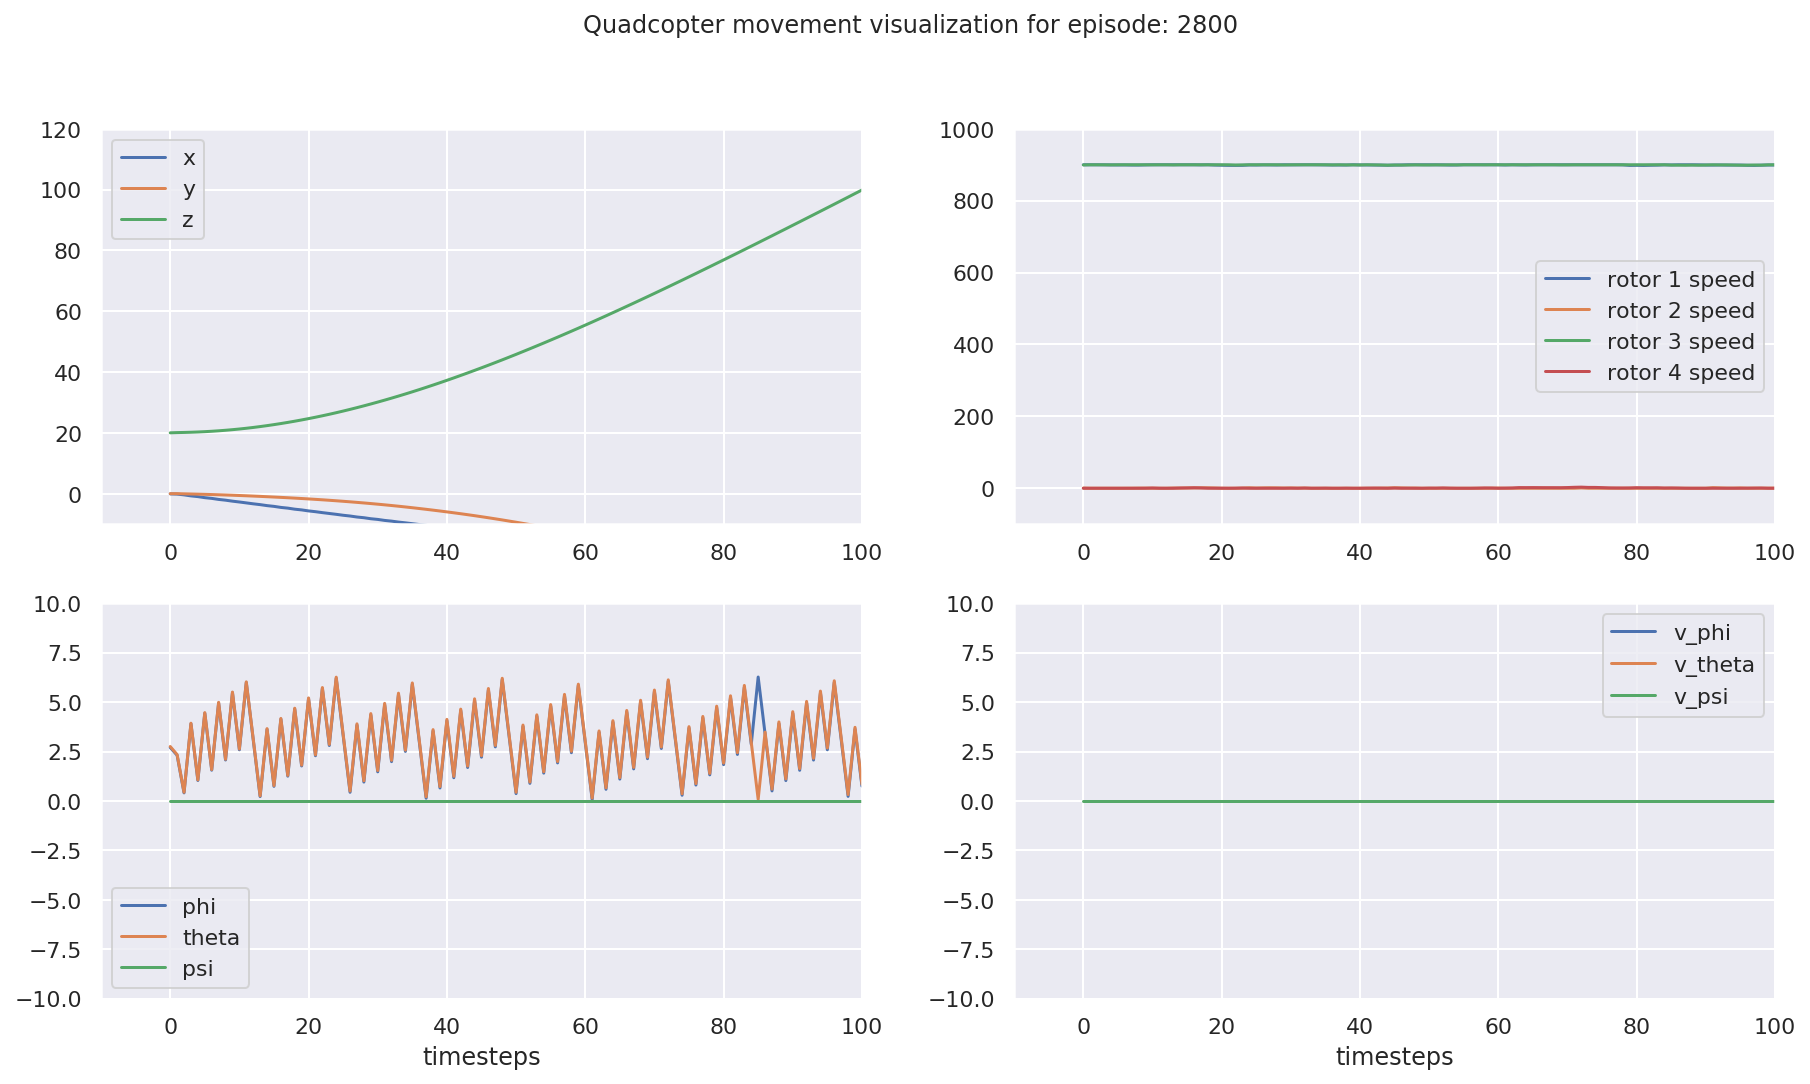

In [18]:
# train the ddpg agent
scores = ddpg_train(agent,env=task,max_episodes=int(3e3),PRINT_EVERY=200,DISPLAY_EVERY=200)

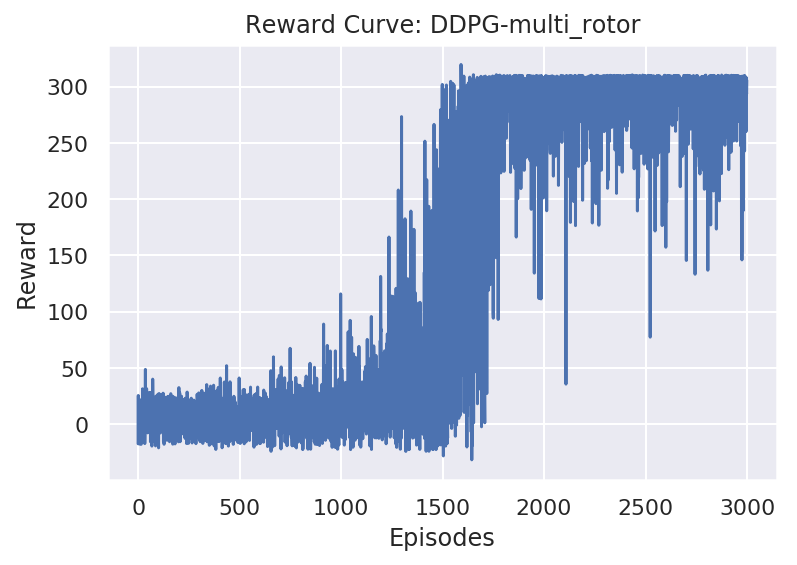

In [19]:
# plot the reward curve
fig = plt.figure()
plt.plot(scores)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward Curve: DDPG-multi_rotor')
plt.savefig('images/reward_curve-multi_rotor.png',dpi=300)
plt.show()

### Watch the smart agent!

Reward: 307.88	 Episode length: 101



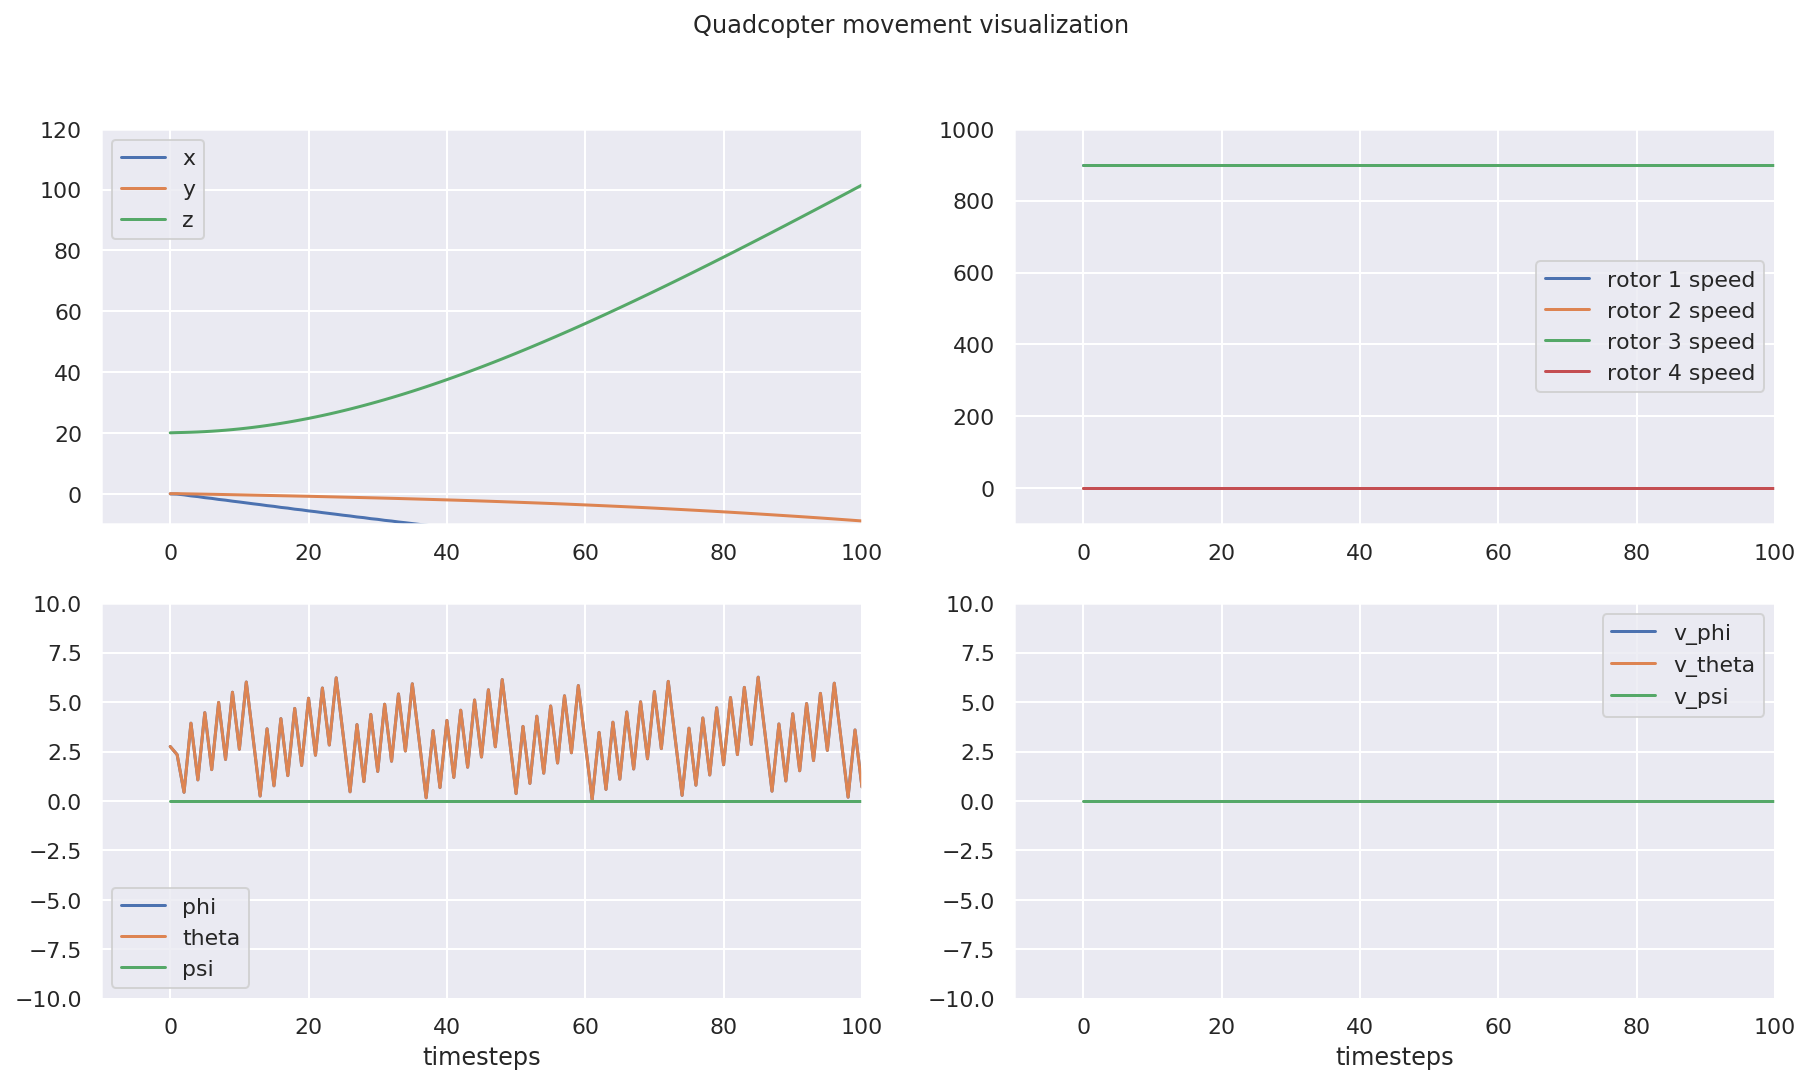

In [20]:
# initialize time step counter and online reward
time_step = 0
online_reward = 0

# initialize logs for storing quad movements
state_log, action_log, v_log, angular_v_log = [],[],[],[]

# reset agent
env = task
state = env.reset()

while True:
    # choose agent action
    action = agent.act(state,add_noise=False)

    # map action to appropriate range
    action_ = (env.action_high - env.action_low)*(action+1)/2 + env.action_low

    # take the next step in the env using the above action
    next_state,reward,done = env.step(action_)

    # update quad movement logs
    state_log.append(env.sim.pose)
    action_log.append(action_)
    v_log.append(env.sim.v)
    angular_v_log.append(env.sim.angular_v)

    # update online reward and time-step counter
    online_reward += reward
    time_step += 1

    # update state
    state = next_state

    if done:
        break

# print training progress
print ("Reward: {:.2f}\t Episode length: {}\n".format(online_reward,time_step))

# visualize quad movements
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

# plot (x,y,z) movements of the quad
state_log = np.array(state_log)
labels = ['x','y','z']
for i in range(len(labels)):
    ax[0,0].plot(state_log[:,i],label=labels[i])
ax[0,0].set_ylim([-10,120])
ax[0,0].set_xlim([-10,100])
ax[0,0].legend()
#ax[0,0].set_xlabel('timesteps')

# plot rotor speeds of the quad
action_log = np.array(action_log)
labels = ['rotor 1 speed','rotor 2 speed','rotor 3 speed','rotor 4 speed']
for i in range(len(labels)):
    ax[0,1].plot(action_log[:,i],label=labels[i])
ax[0,1].set_ylim([-100,1000])
ax[0,1].set_xlim([-10,100])
ax[0,1].legend()
#ax[0,1].set_xlabel('timesteps')

# plot movements of the quad along the euler angles (phi,theta,psi)
labels = ['phi','theta','psi']
for i in range(len(labels)):
    ax[1,0].plot(state_log[:,3+i],label=labels[i])
ax[1,0].set_ylim([-10,10])
ax[1,0].set_xlim([-10,100])
ax[1,0].legend()
ax[1,0].set_xlabel('timesteps')

# plot angular velocities of the quad along the 3 main axis
angular_v_log = np.array(angular_v_log)
labels = ['v_phi','v_theta','v_psi']
for i in range(len(labels)):
    ax[1,1].plot(angular_v_log[:,i],label=labels[i])
ax[1,1].set_ylim([-10,10])
ax[1,1].set_xlim([-10,100])
ax[1,1].legend()
ax[1,1].set_xlabel('timesteps')

fig.suptitle("Quadcopter movement visualization")
plt.savefig("images/quad_movement-multi_rotor.png",dpi=300)
plt.show()